In [29]:
# check the current python version, make sure this is the one that with HDDM correctly installed
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current HDDM version is', python_version())

import hddm, IPython
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
#print('The current IPython version is', IPython.__version__) 

import os
cur_dir = os.getcwd()
print('The current working directory is', cur_dir)


Notebook is running: /opt/conda/bin/python
The current HDDM version is 3.7.6
The current HDDM version is 0.8.0
The current working directory is /home/jovyan/example


In [30]:
import ipyparallel as ipp
rc = ipp.Client()
rc.ids

[0, 1, 2, 3]

In [31]:
def foo():
    import time
    time.sleep(5)
    return 'foo'

def bar():
    import time
    time.sleep(10) 
    return 'bar'  

res1 = rc[0].apply(foo)
res2 = rc[1].apply(bar)
results = [res1, res2]

while not all(map(lambda ar: ar.ready(), results)):
    pass

print(res1.get(), res2.get())

foo bar


In [32]:
dv = rc[:]

res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [33]:
@dv.remote(block = True)
def f1(n):
    import numpy as np
    return np.random.rand(n)
f1(4)

[array([0.83971861, 0.09812938, 0.67815021, 0.75934717]),
 array([0.06861878, 0.73081206, 0.76607639, 0.91337977]),
 array([0.1935394 , 0.47151174, 0.34946135, 0.4155981 ]),
 array([0.33002902, 0.79535145, 0.42538416, 0.79215447])]

In [34]:
%matplotlib inline

# Preparation
import os, time, csv, datetime
import kabuki, hddm
from kabuki.analyze import gelman_rubin

from datetime import date

# import the toolbox
import random
import pandas as pd
import matplotlib.pyplot as plt

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

In [35]:
# load data from cateogriztion based on moral valence
dat_M_match = hddm.load_csv('temp_HDDM_reg.csv')

dat_M_match.head(12)  

subj_idx    person     match  stim  accuracy  response     rt  early  \
0         12      Self     match     1         1         1  0.748 -0.509   
1         12  Stranger  mismatch     0         0         1  1.014  0.212   
2         12    Friend  mismatch     0         1         0  0.772  0.398   
3         12    Friend     match     1         1         1  0.834 -1.264   
4         12      Self     match     1         1         1  0.579 -0.509   
5         12      Self  mismatch     0         1         0  0.804  1.364   
6         12  Stranger  mismatch     0         1         0  0.854  0.212   
7         12      Self  mismatch     0         1         0  0.806  1.364   
8         12  Stranger     match     1         1         1  0.709 -0.467   
9         12  Stranger     match     1         1         1  0.718 -0.467   
10        12  Stranger  mismatch     0         1         0  0.716  0.212   
11        12      Self  mismatch     0         1         0  0.647  1.364   

       n1     p3  alpha  gammal  gammah  Unnamed: 13  n1_raw  p3_raw  
0  -0.302  1.269 -3.020  -0.019  -0.219          NaN  -5.400   9.690  
1  -0.336  0.273 -0.663  -0.578  -1.812          NaN  -5.474   6.132  
2  -1.000 -0.378 -0.642  -0.540   0.066          NaN  -6.907   3.805  
3  -0.158  0.712 -3.026   0.356  -0.193          NaN  -5.090   7.700  
4  -0.302  1.269 -3.020  -0.019  -0.219          NaN  -5.400   9.690  
5   1.076  0.532 -0.270  -0.506  -0.029          NaN  -2.428   7.055  
6  -0.336  0.273 -0.663  -0.578  -1.812          NaN  -5.474   6.132  
7   1.076  0.532 -0.270  -0.506  -0.029          NaN  -2.428   7.055  
8   0.013  0.301 -3.231   0.442   0.139          NaN  -4.720   6.230  
9   0.013  0.301 -3.231   0.442   0.139          NaN  -4.720   6.230  
10 -0.336  0.273 -0.663  -0.578  -1.812          NaN  -5.474   6.132  
11  1.076  0.532 -0.270  -0.506  -0.029          NaN  -2.428   7.055

In [36]:
nsample = 1000     # number of sampling
nburn   = 100     # number of burn

# dateToday = str(date.today())  # replace the code below if you prefer using the actual date
dateToday = 'final' # using final in the saved file name


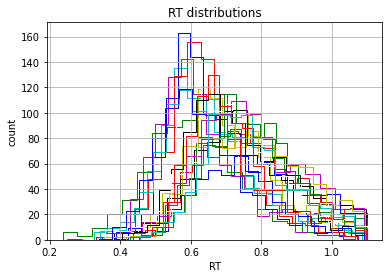

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in dat_M_match.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('temp_hddm_flipped.pdf')

In [10]:
#### stimulus coding: transfer z scores to positive/negative infinite while linking to the two types of stimulus (match vs. mistach)

import numpy as np 

def z_link_func(x, data=dat_M_match):
    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                             {'s': data.stimulus.ix[x.index]}))
           )
    return 1/(1 + np.exp(-(x * stim)))

In [ ]:
##### accuracy coding: transfer z scores to positive/negative infinite

import numpy as np 

def z_link_func(x, data=dat_M_match):
    return 1/(1 + np.exp(-(x)))

### Moldel 1 : test models, nonmatch 

In [11]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "M_match_m1"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):alpha', 'link_func': lambda x: x}

M_match_m1 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
M_match_m1.find_starting_values()
M_match_m1.sample(nsample, burn=nburn, dbname='v_bwsubs_int.db', db='pickle')

# save the model
M_match_m1.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("M_match_m1 DIC: %f" %M_match_m1.dic) #
M_match_m1.print_stats() # check values of reg coefficients against the generated ones


Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:alpha', 'v_C(match + person)[matchSelf]:alpha', 'v_C(match + person)[matchStranger]:alpha', 'v_C(match + person)[mismatchFriend]:alpha', 'v_C(match + person)[mismatchSelf]:alpha', 'v_C(match + person)[mismatchStranger]:alpha']
 [-----------------100%-----------------] 2001 of 2000 complete in 105132.3 secWARNING: Will not save custom link functions.
M_match_m1 DIC: -10023.111394
                                                  mean         std        2.5q        25q        50q         75q      97.5q       mc err
a                                             0.999464   0.0201651    0.958335   0.986645   0.999572     1.01281    1.03852  0.000744688
a_std                                        0.0767612   0.0159399   0

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:alpha
Plotting v_C(match + person)[matchSelf]:alpha
Plotting v_C(match + person)[matchStranger]:alpha
Plotting v_C(match + person)[mismatchFriend]:alpha
Plotting v_C(match + person)[mismatchSelf]:alpha
Plotting v_C(match + person)[mismatchStranger]:alpha


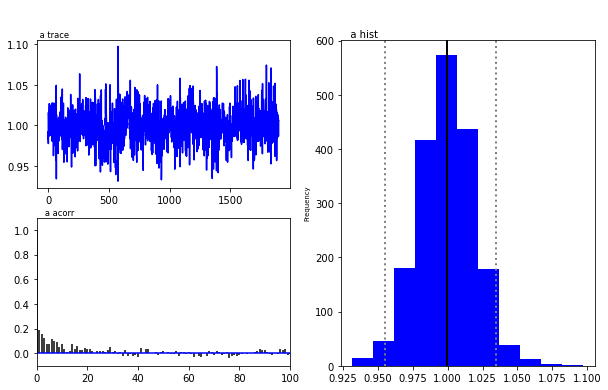

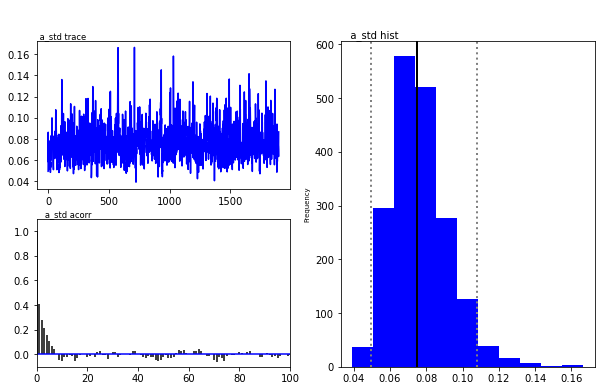

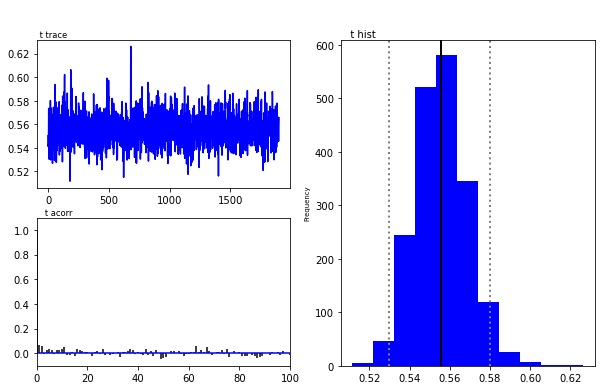

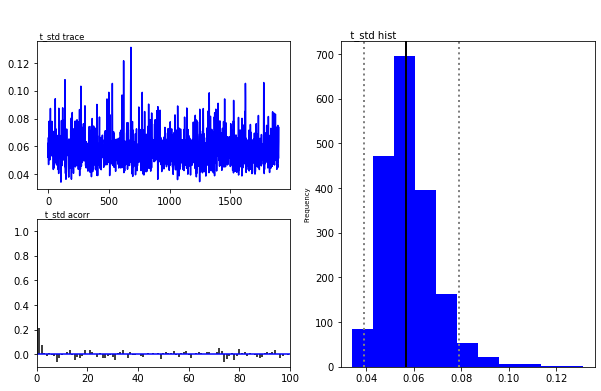

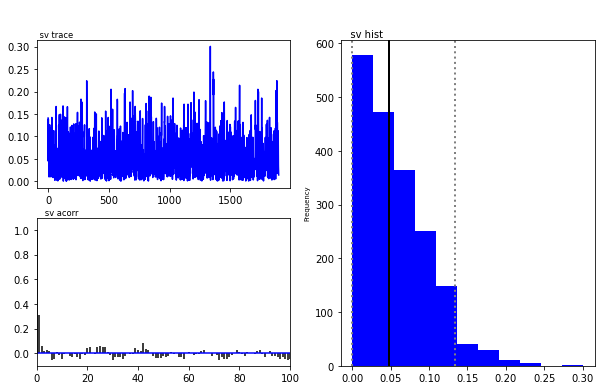

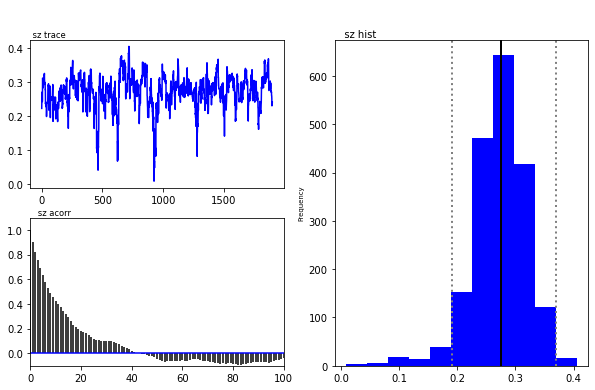

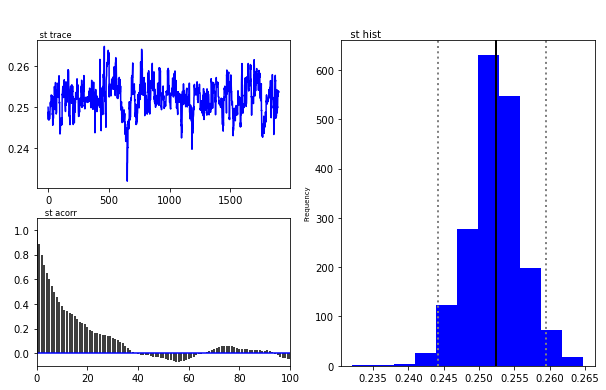

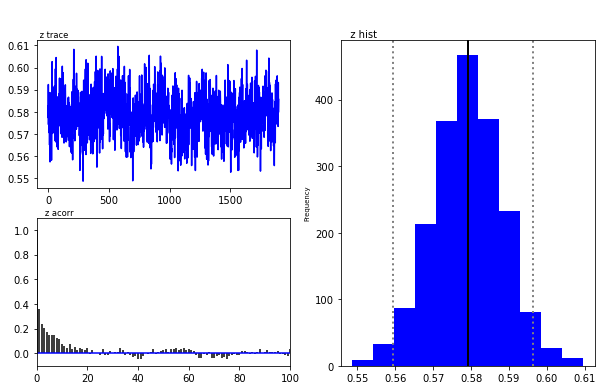

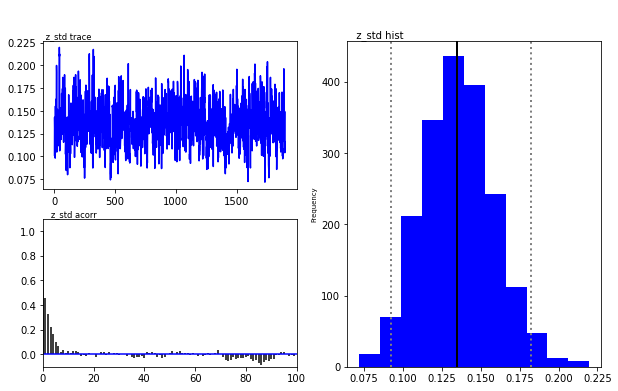

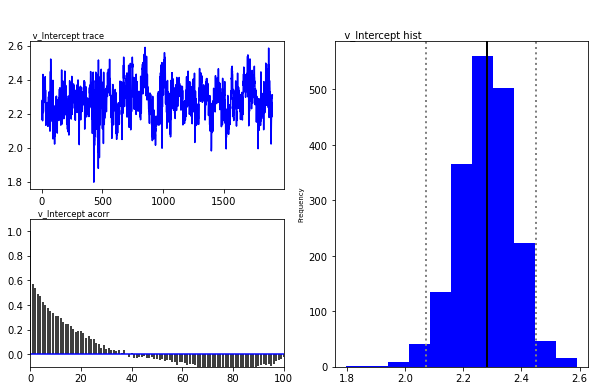

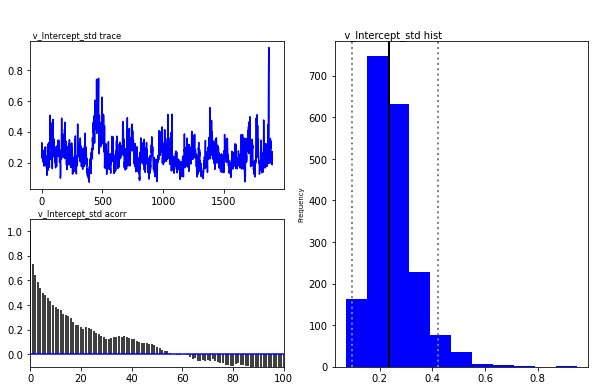

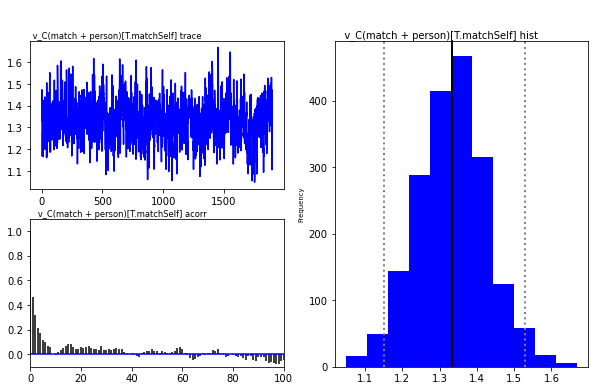

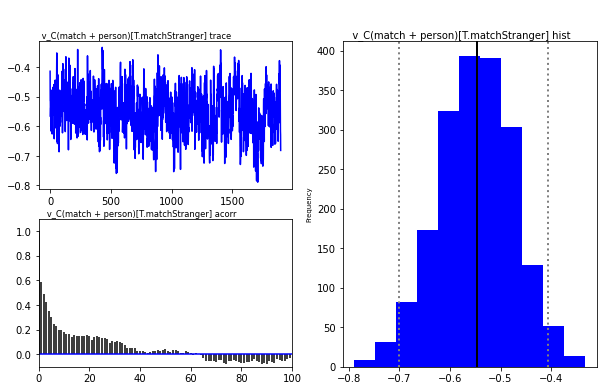

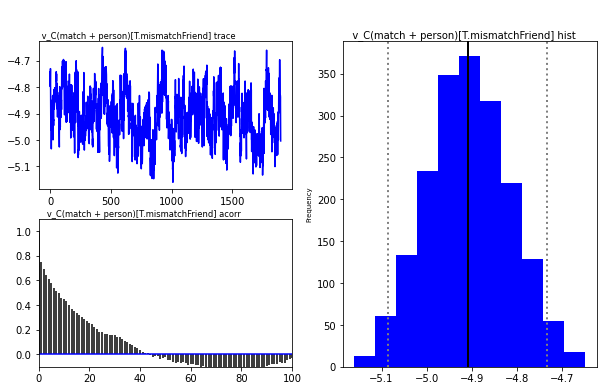

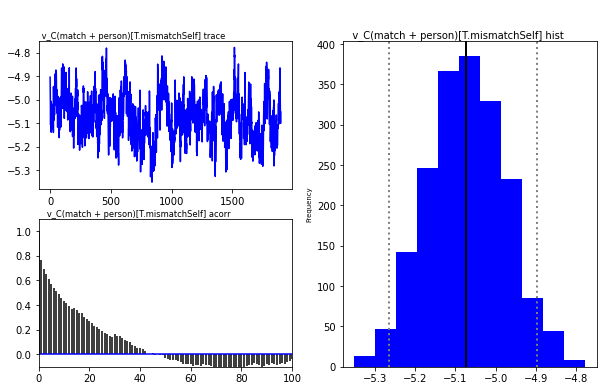

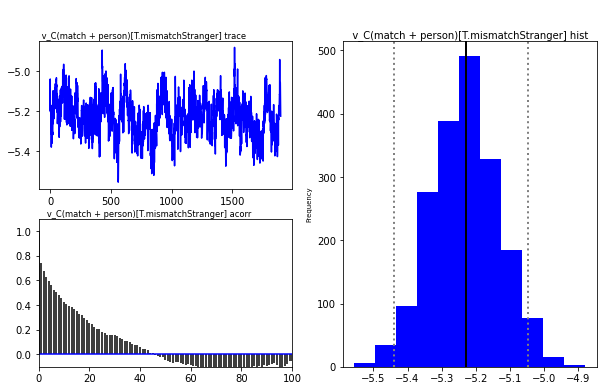

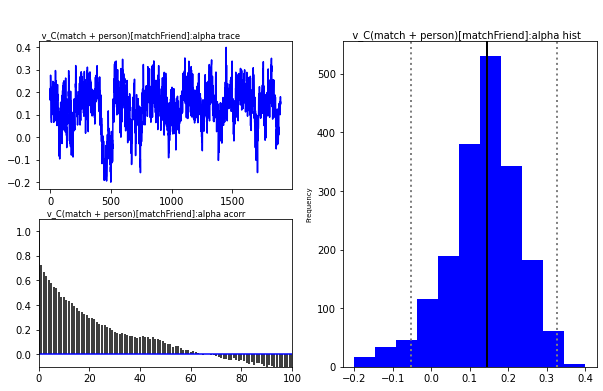

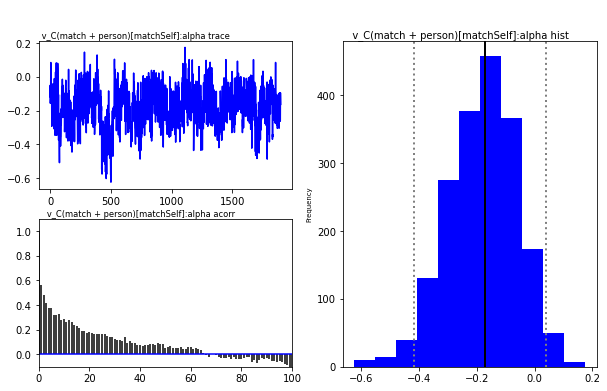

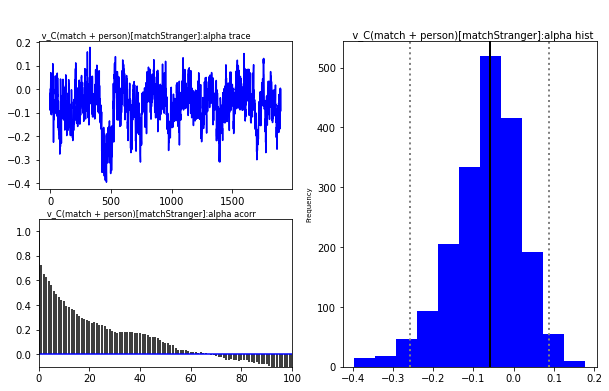

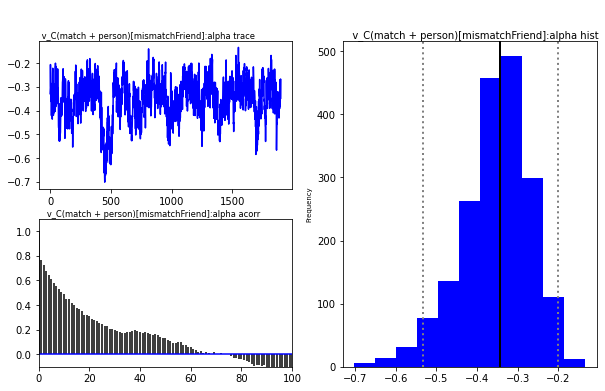

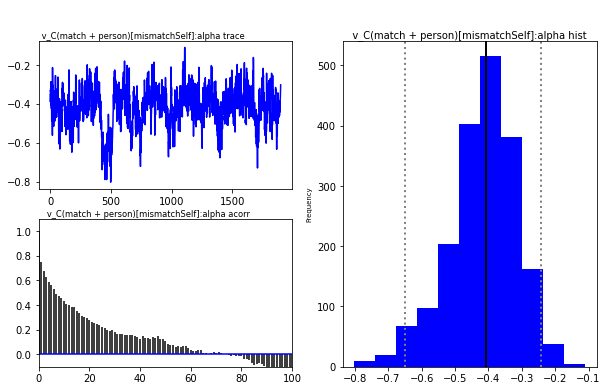

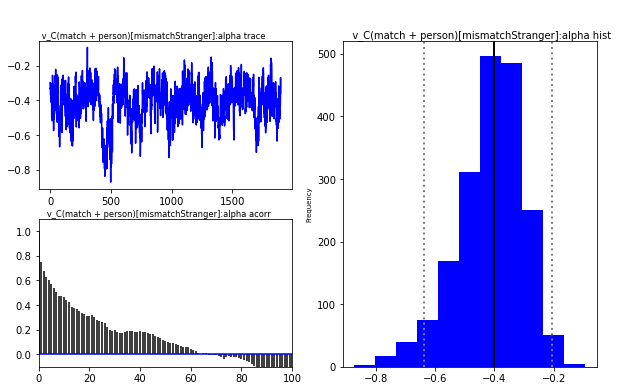

In [13]:
z_link_func

### Model 2

In [23]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m2"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):early', 'link_func': lambda x: x}
z_reg = {'model': 'z ~1 + C(match + person) + C(match + person):early', 'link_func': lambda x: x}
z_reg = {'model': 'z ~ early', 'link_func': lambda x: x}
a_reg = {'model': 'a ~ early', 'link_func': lambda x: x}
vtza_reg = [v_reg, t_reg, z_reg, a_reg]

reg_m2 = hddm.HDDMRegressor(dat_M_match, vtza_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m2.find_starting_values()
reg_m2.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m2.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m2 DIC: %f" %reg_m2.dic) #
reg_m2.print_stats() # check values of reg coefficients against the generated ones




Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:early', 'v_C(match + person)[matchSelf]:early', 'v_C(match + person)[matchStranger]:early', 'v_C(match + person)[mismatchFriend]:early', 'v_C(match + person)[mismatchSelf]:early', 'v_C(match + person)[mismatchStranger]:early']
Adding these covariates:
['t_Intercept', 't_C(match + person)[T.matchSelf]', 't_C(match + person)[T.matchStranger]', 't_C(match + person)[T.mismatchFriend]', 't_C(match + person)[T.mismatchSelf]', 't_C(match + person)[T.mismatchStranger]', 't_C(match + person)[matchFriend]:early', 't_C(match + person)[matchSelf]:early', 't_C(match + person)[matchStranger]:early', 't_C(match + person)[mismatchFriend]:early', 't_C(match + person)[mismatchSelf]:early', 't_C(match + person)[mismatchStranger]:early'

In [25]:
###### get traces

reg_m2_group_trace = reg_m2.get_group_traces()
reg_m2_trace = reg_m2.get_traces()

reg_m2_group_trace.to_csv('reg_m2_group_traces.csv')
reg_m2_trace.to_csv('reg_m2_traces.csv')

# a, b = reg_m2.nodes_db.node[['v_C(match)[Self]:early','v_C(match)[Friend]:early']]

# hddm.analyze.plot_posterior_nodes([a, b]) print ("P() = ", ( ( a.trace()) > 0).mean()) print ("P() = ", ( ( b.trace()) < 0).mean()) print ("P() = ", ( ( a.trace()) < b.trace()).mean()) 


Plotting sv
Plotting sz
Plotting st
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:early
Plotting v_C(match + person)[matchSelf]:early
Plotting v_C(match + person)[matchStranger]:early
Plotting v_C(match + person)[mismatchFriend]:early
Plotting v_C(match + person)[mismatchSelf]:early
Plotting v_C(match + person)[mismatchStranger]:early
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_C(match + person)[T.matchSelf]
Plotting t_C(match + person)[T.matchStranger]
Plotting t_C(match + person)[T.mismatchFriend]
Plotting t_C(match + person)[T.mismatchSelf]
Plotting t_C(match + person)[T.mismatchStranger]
Plotting t_C(match + person)[matchFriend]:early
Plotting t_C(match + person)[matchSelf]:early
Plotting t_C(match + pe

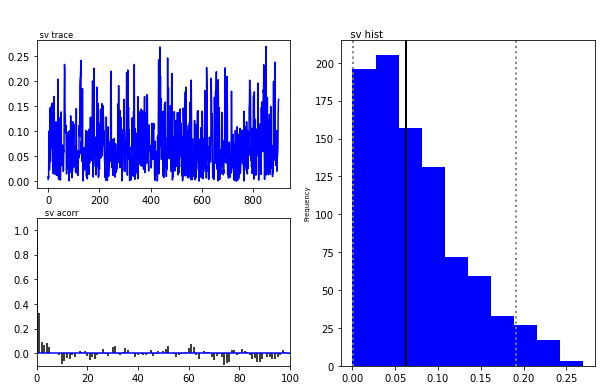

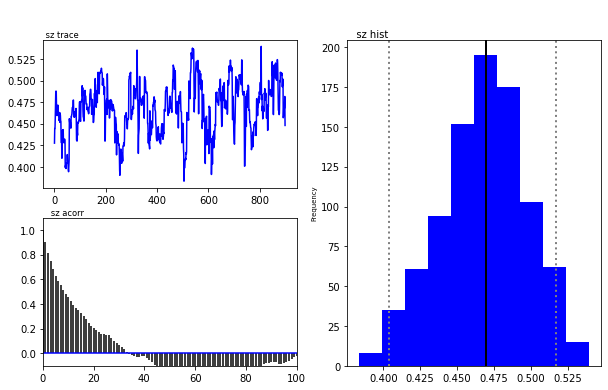

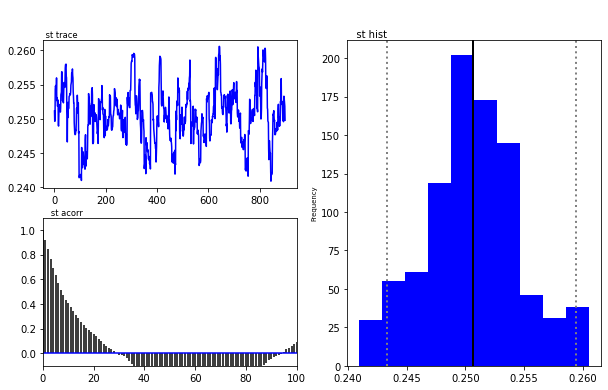

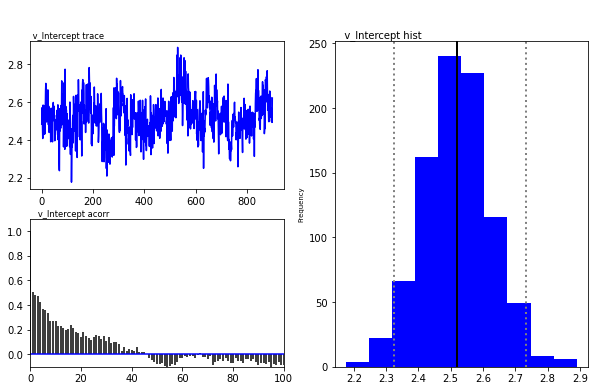

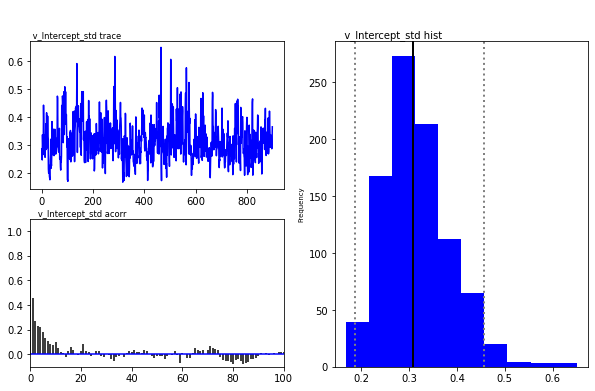

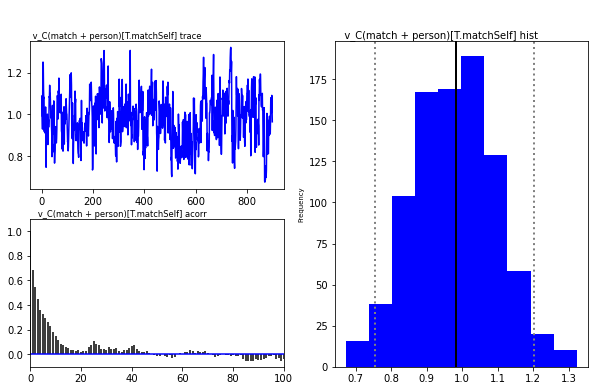

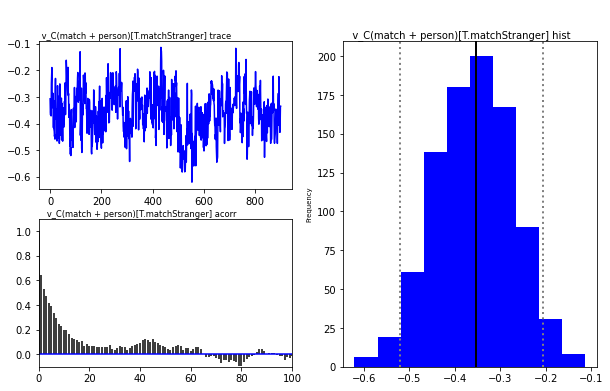

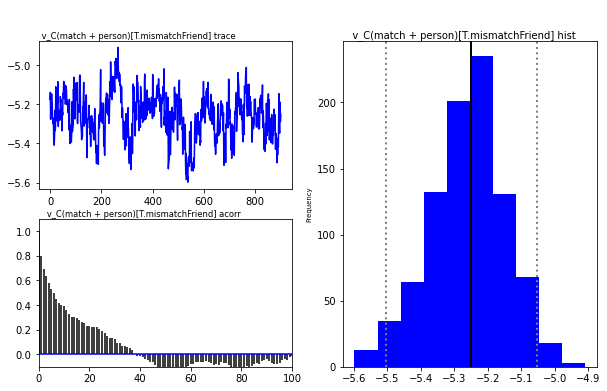

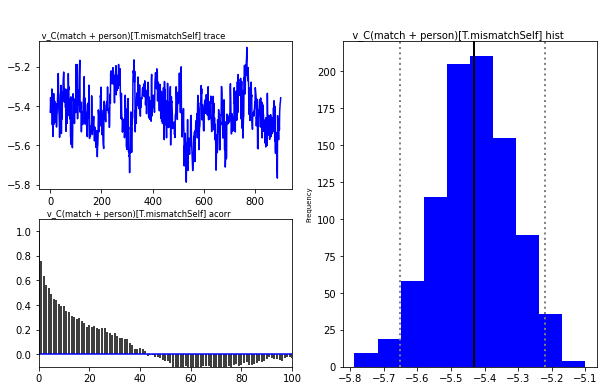

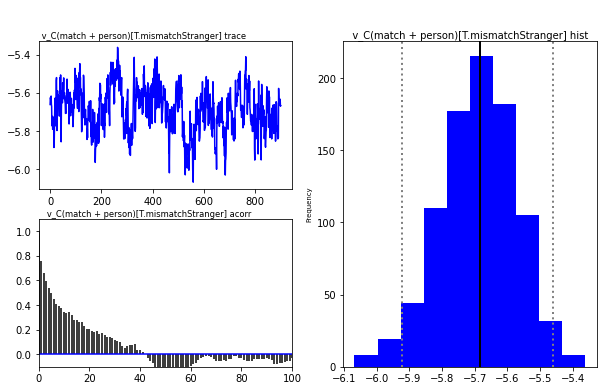

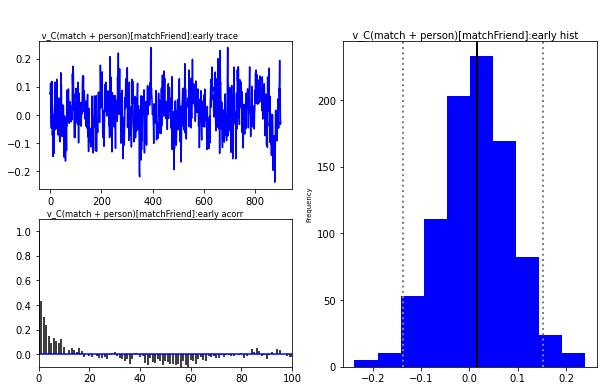

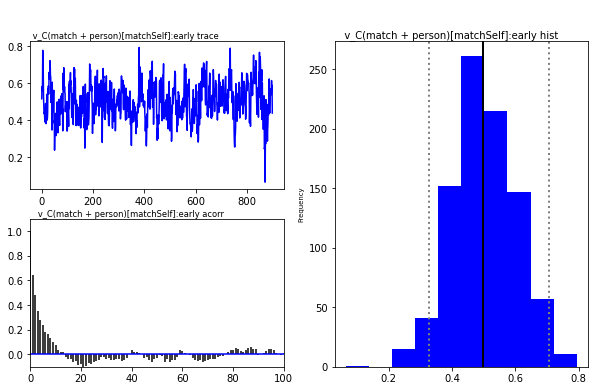

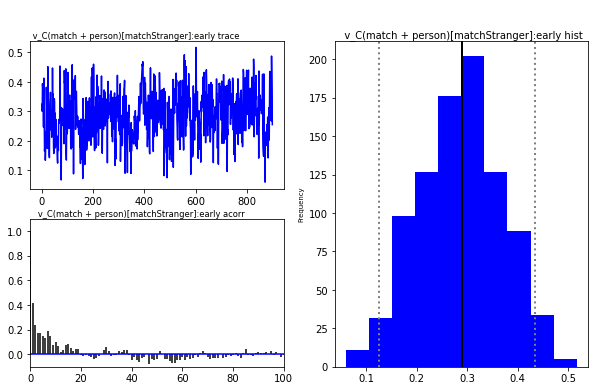

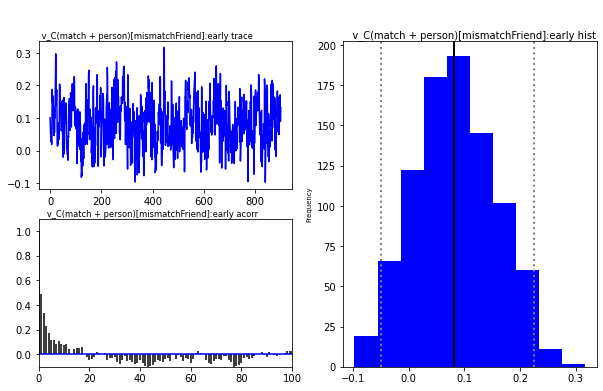

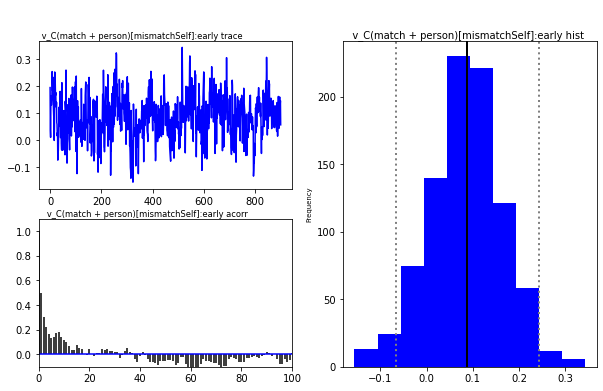

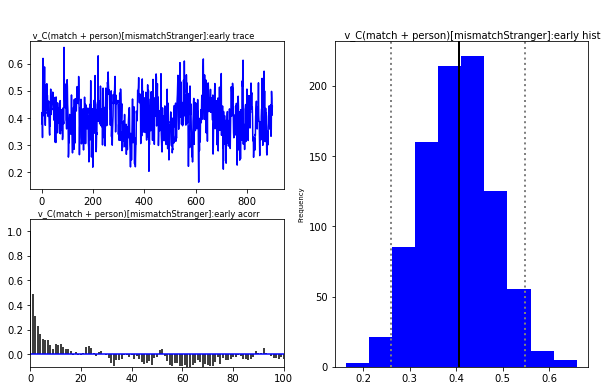

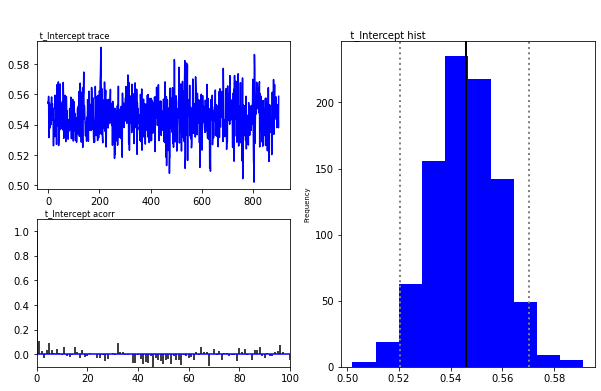

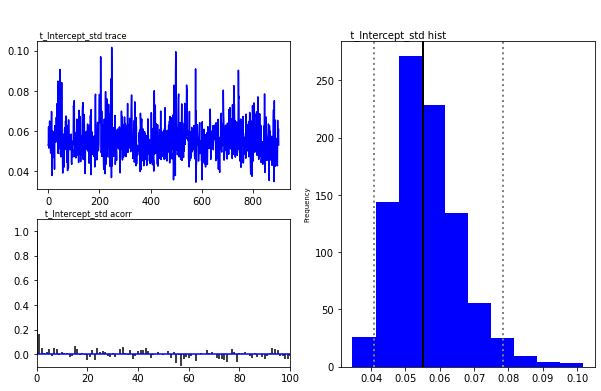

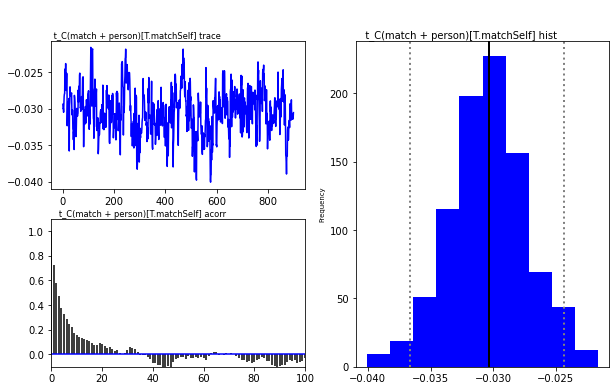

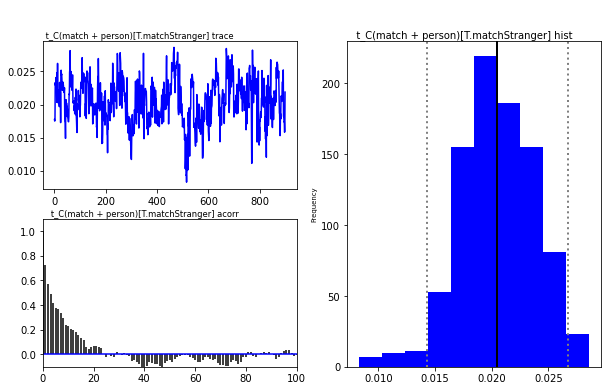

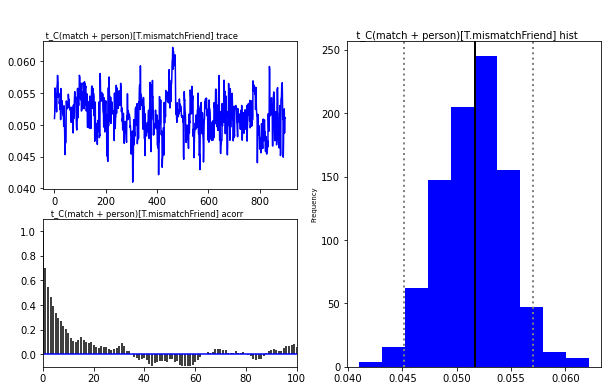

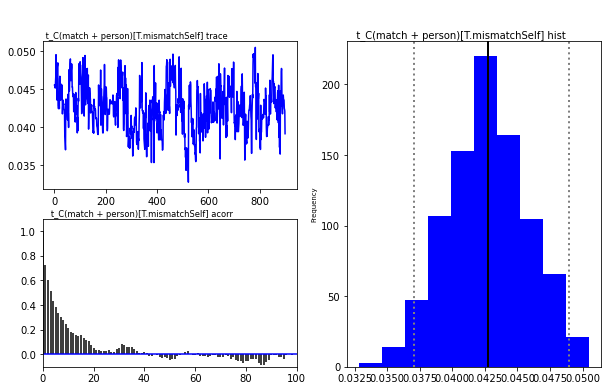

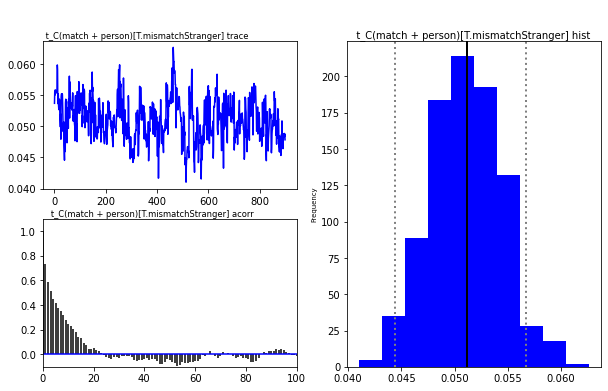

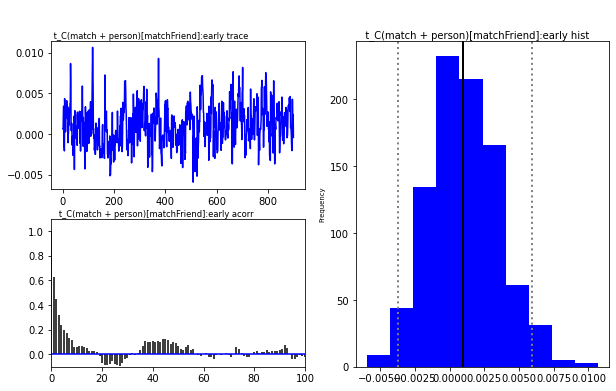

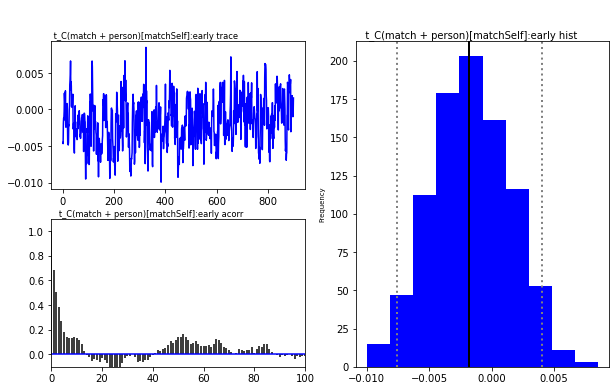

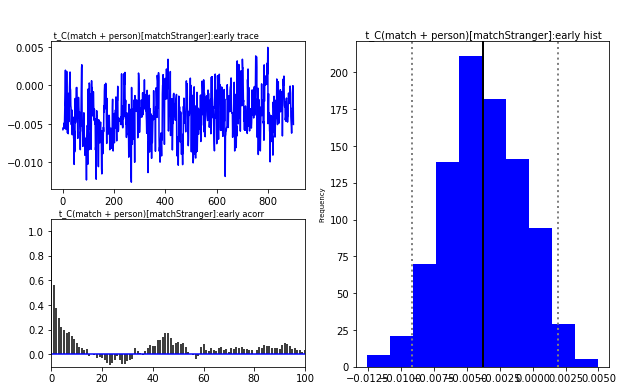

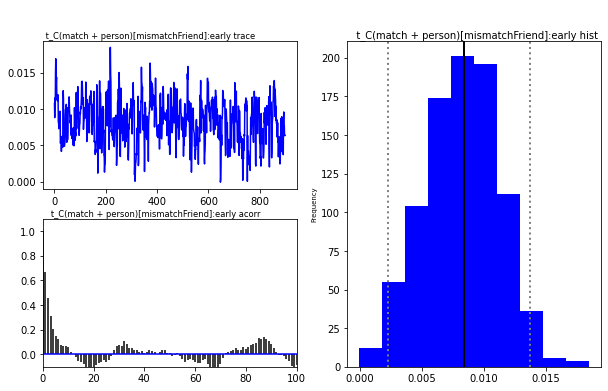

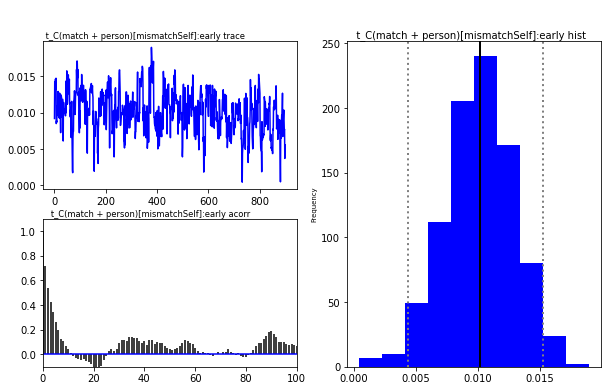

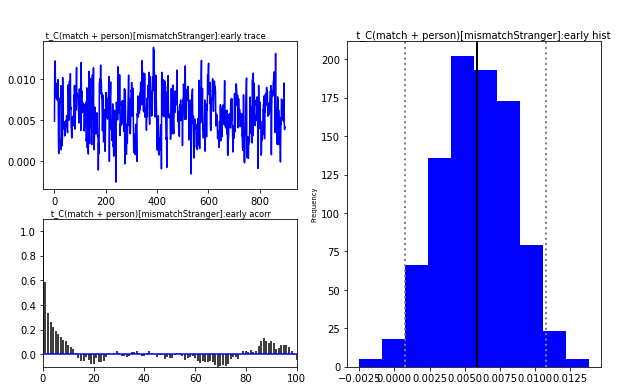

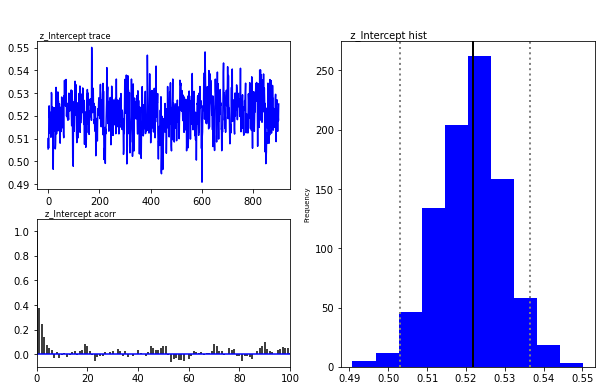

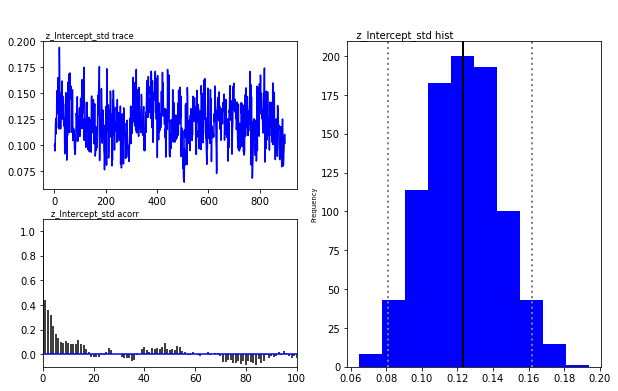

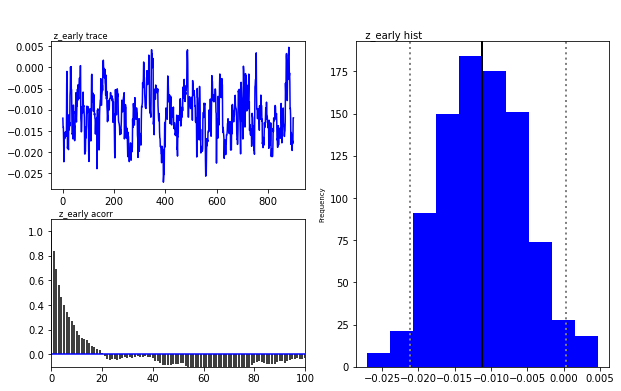

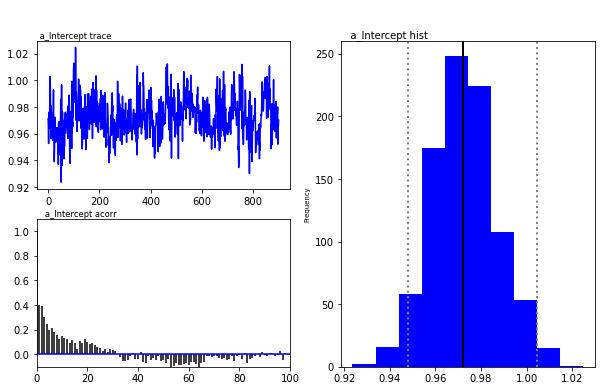

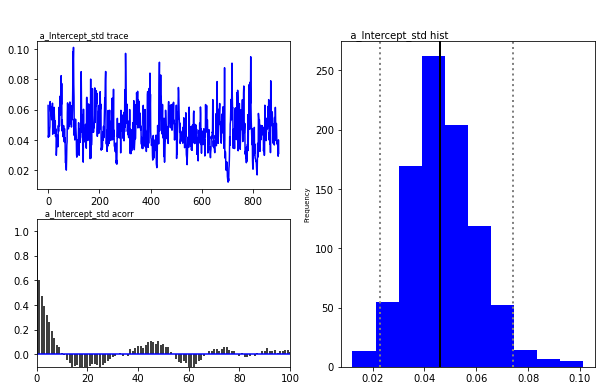

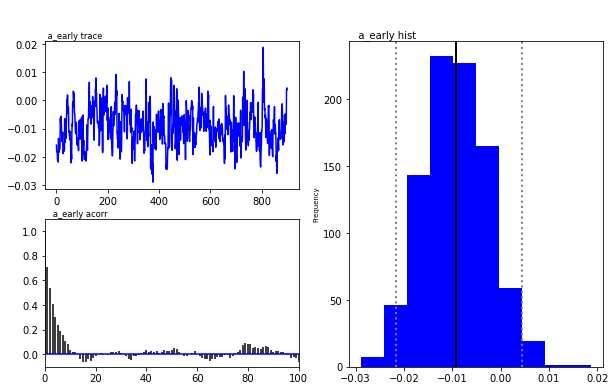

In [26]:
###### convergence check
reg_m2.plot_posteriors()




### Model 3

In [12]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m3"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):early', 'link_func': lambda x: x}
# t_reg = {'model': 't ~1 + C(match + person) + C(match + person):early', 'link_func': lambda x: x}
z_reg = {'model': 'z ~1 + C(person) + C(person):early', 'link_func': lambda x: x}
# a_reg = {'model': 'a ~ early', 'link_func': lambda x: x}
vz_reg = [v_reg, z_reg]

reg_m3 = hddm.HDDMRegressor(dat_M_match, vz_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m3.find_starting_values()
reg_m3.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m3.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m3 DIC: %f" %reg_m3.dic) #
reg_m3.print_stats() # check values of reg coefficients against the generated ones




Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:early', 'v_C(match + person)[matchSelf]:early', 'v_C(match + person)[matchStranger]:early', 'v_C(match + person)[mismatchFriend]:early', 'v_C(match + person)[mismatchSelf]:early', 'v_C(match + person)[mismatchStranger]:early']
Adding these covariates:
['z_Intercept', 'z_C(person)[T.Self]', 'z_C(person)[T.Stranger]', 'z_C(person)[Friend]:early', 'z_C(person)[Self]:early', 'z_C(person)[Stranger]:early']
 [-----------------100%-----------------] 1001 of 1000 complete in 58552.8 secWARNING: Will not save custom link functions.
reg_m3 DIC: -10182.432356
                                                   mean         std        2.5q         25q         50q         75q        97.5q       mc err
a                            

In [13]:
###### get traces

reg_m3_group_trace = reg_m3.get_group_traces()
reg_m3_trace = reg_m3.get_traces()

reg_m3_group_trace.to_csv('reg_m3_group_traces.csv')
reg_m3_trace.to_csv('reg_m3_traces.csv')

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:early
Plotting v_C(match + person)[matchSelf]:early
Plotting v_C(match + person)[matchStranger]:early
Plotting v_C(match + person)[mismatchFriend]:early
Plotting v_C(match + person)[mismatchSelf]:early
Plotting v_C(match + person)[mismatchStranger]:early
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(person)[T.Self]
Plotting z_C(person)[T.Stranger]
Plotting z_C(person)[Friend]:early
Plotting z_C(person)[Self]:early
Plotting z_C(person)[Stranger]:early


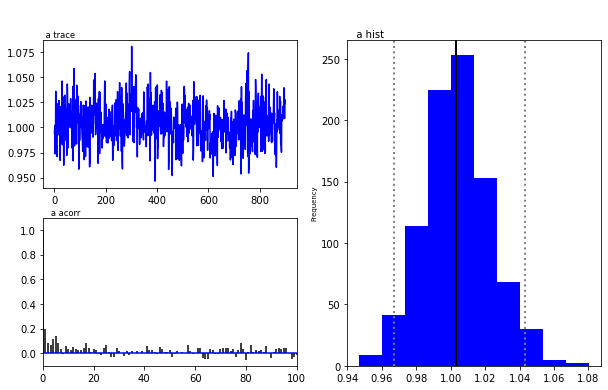

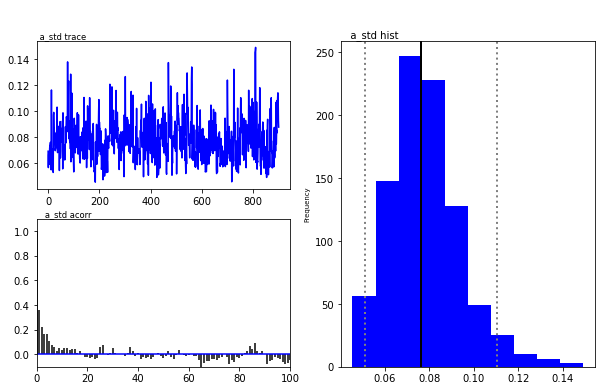

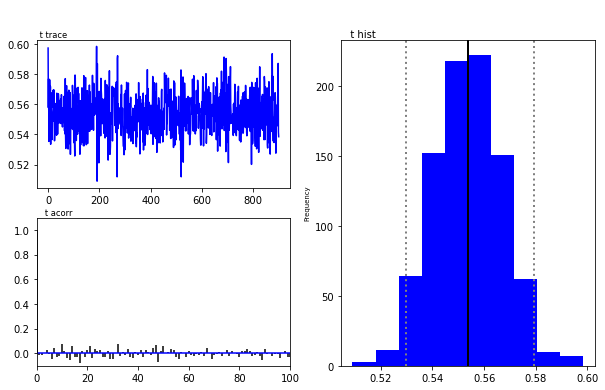

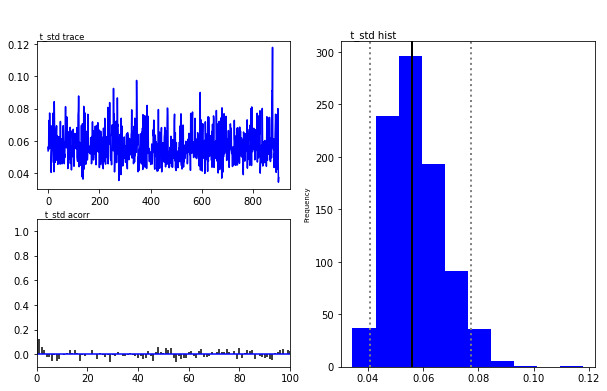

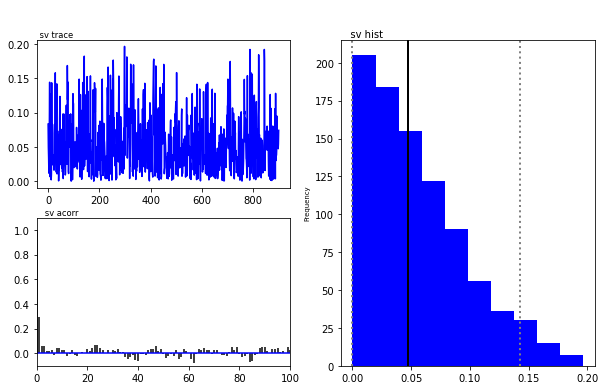

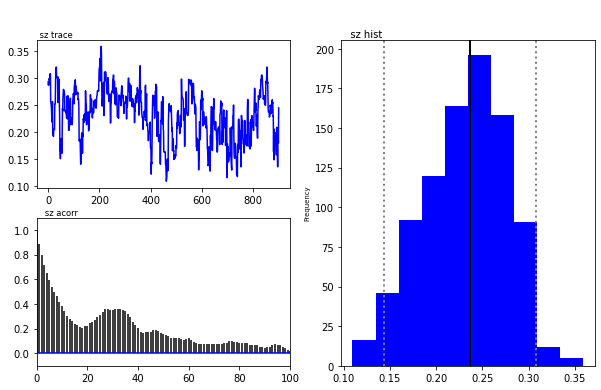

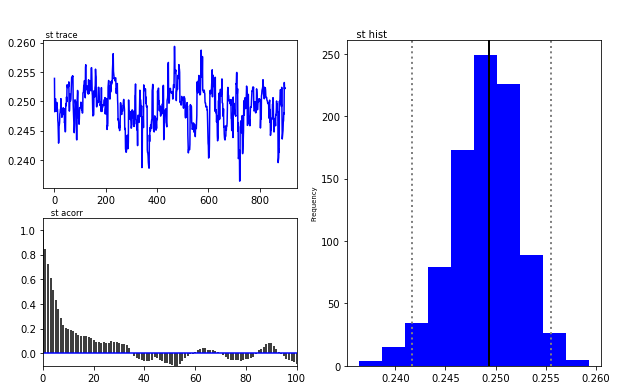

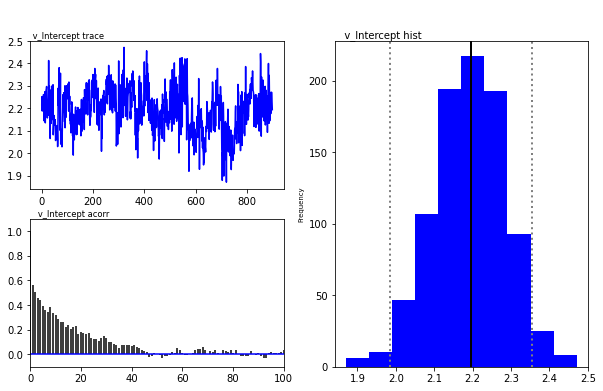

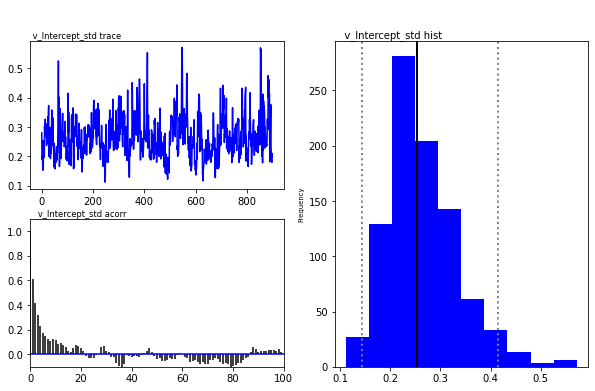

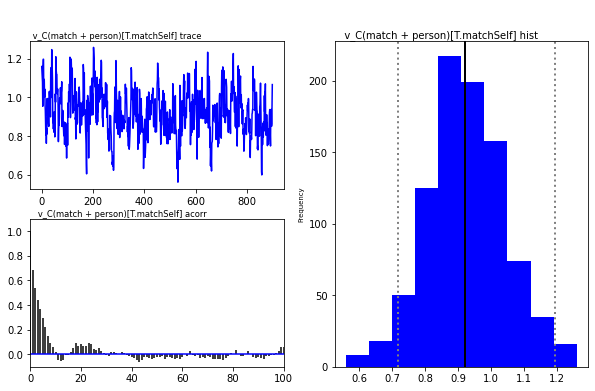

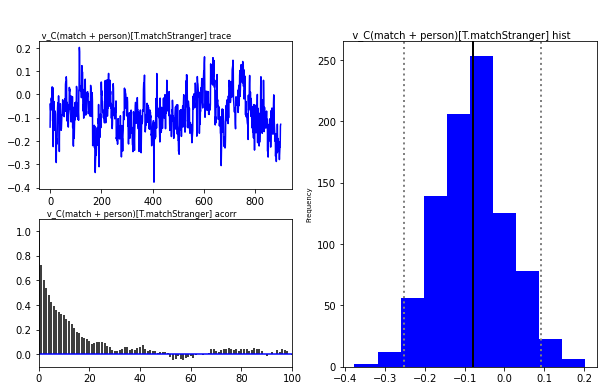

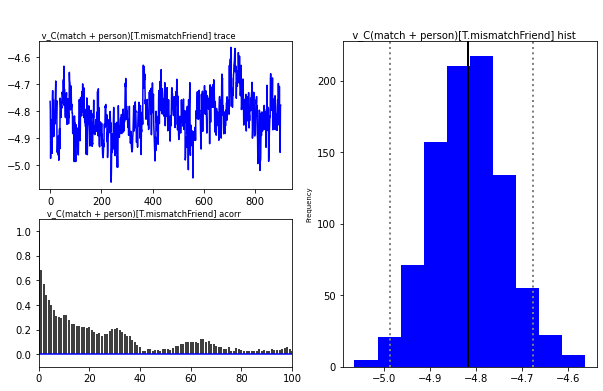

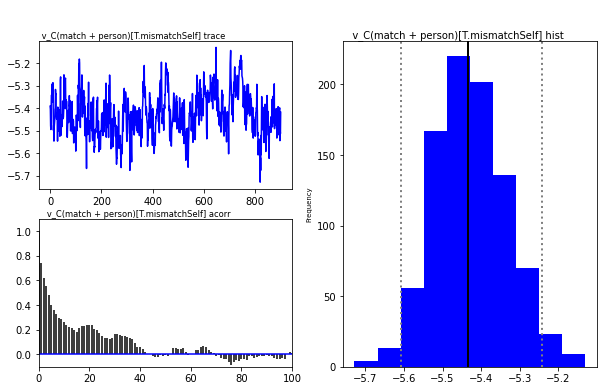

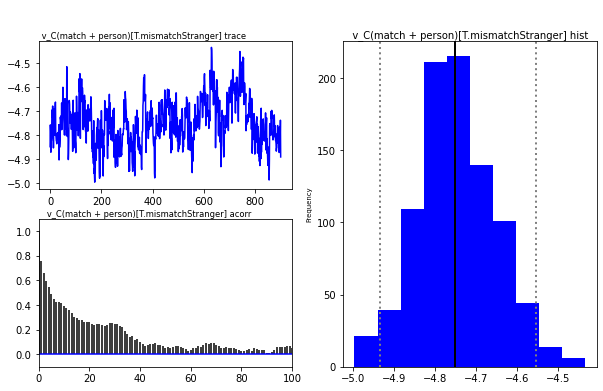

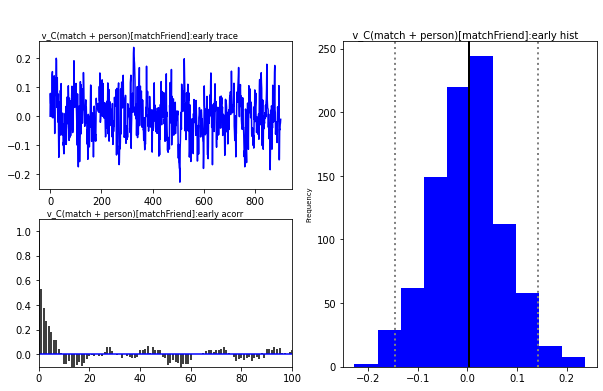

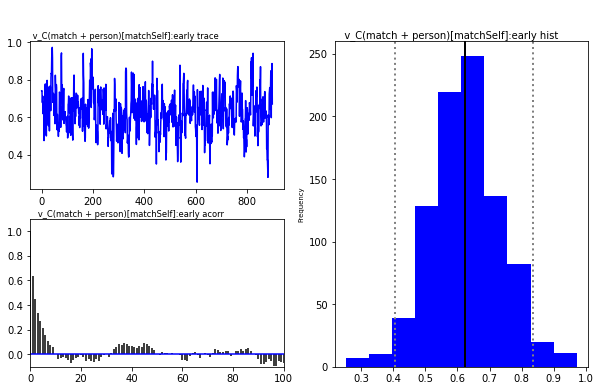

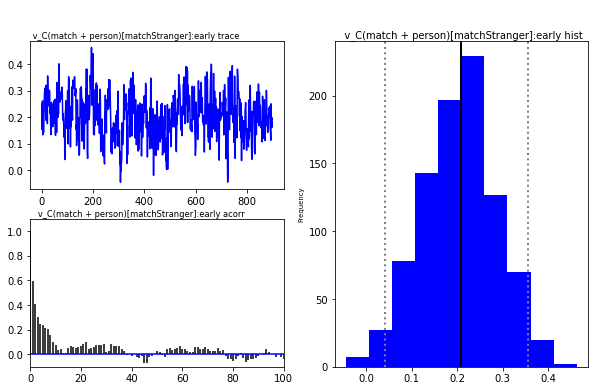

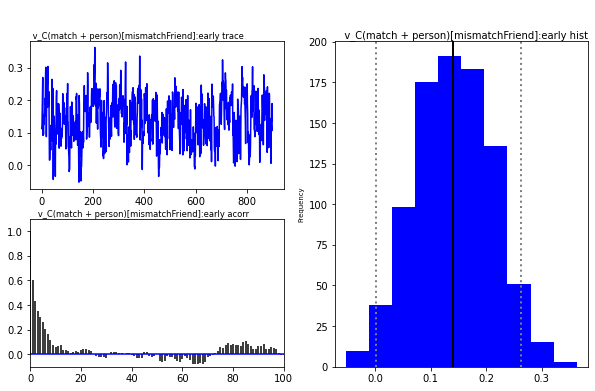

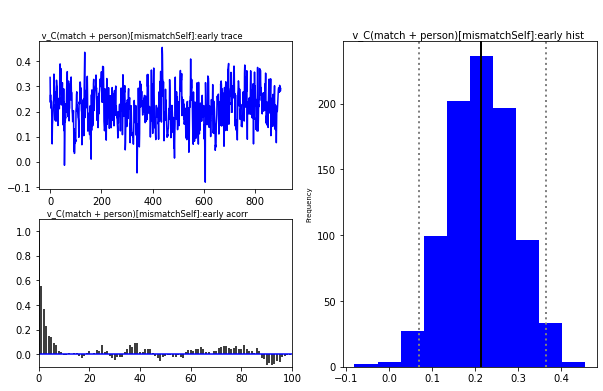

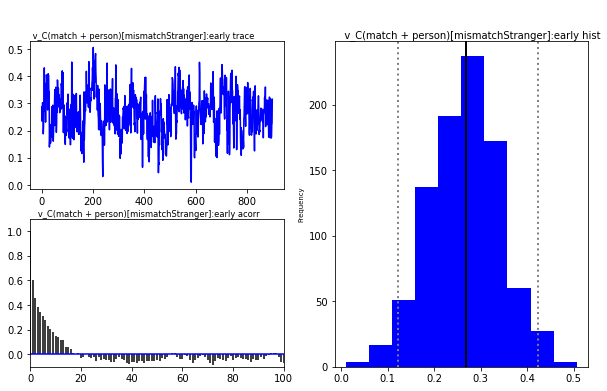

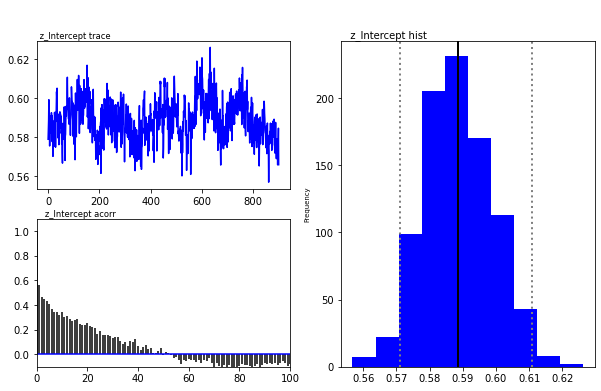

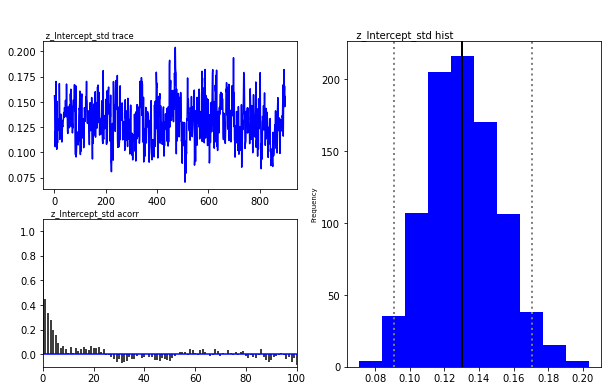

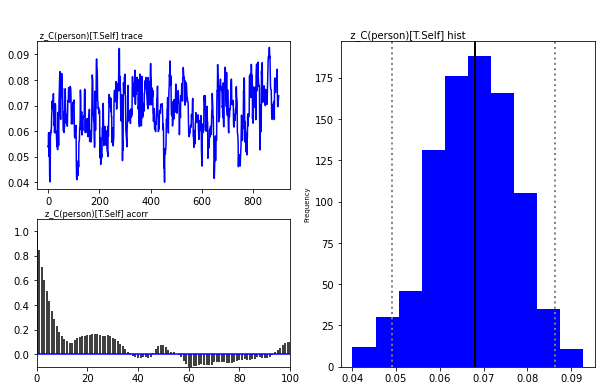

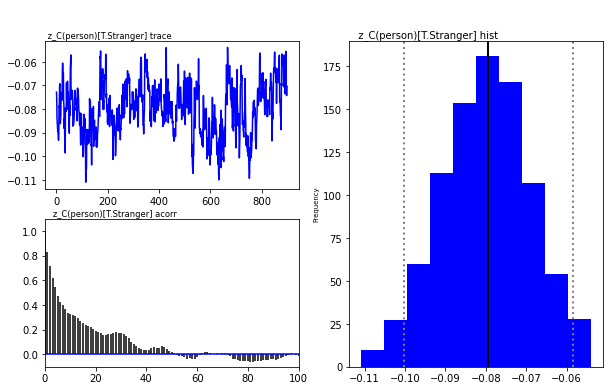

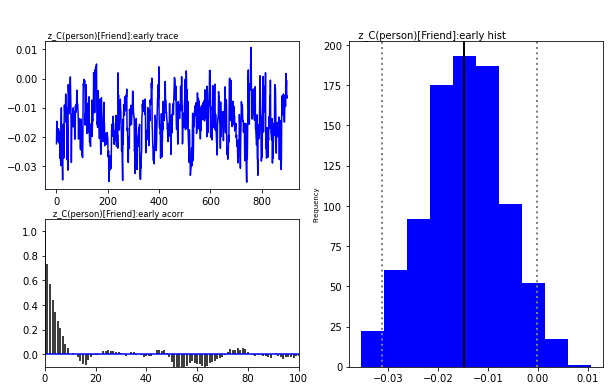

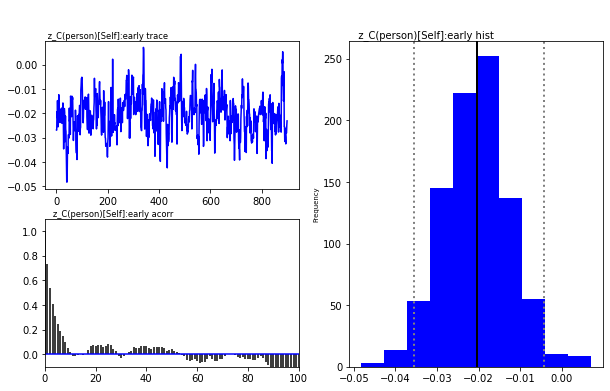

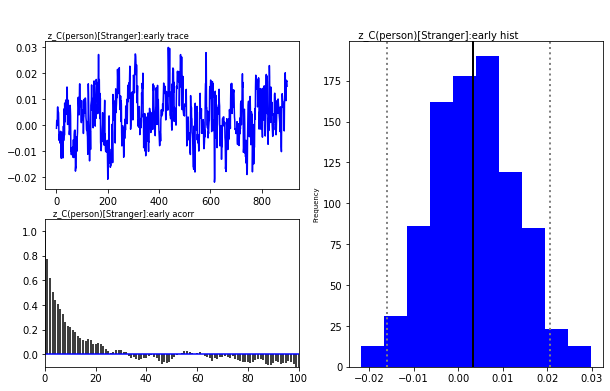

In [14]:
###### convergence check
reg_m3.plot_posteriors()


In [15]:
######################### Model 4: early: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m4"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):early', 'link_func': lambda x: x}
# z_reg = {'model': 'z ~1 + C(match + person)', 'link_func': lambda x: x}
# vz_reg = [v_reg, z_reg]

reg_m4 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m4.find_starting_values()
reg_m4.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m4.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m4 DIC: %f" %reg_m4.dic) #
reg_m4.print_stats() # check values of reg coefficients against the generated ones




Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:early', 'v_C(match + person)[matchSelf]:early', 'v_C(match + person)[matchStranger]:early', 'v_C(match + person)[mismatchFriend]:early', 'v_C(match + person)[mismatchSelf]:early', 'v_C(match + person)[mismatchStranger]:early']
 [-----------------100%-----------------] 1001 of 1000 complete in 42293.7 secWARNING: Will not save custom link functions.
reg_m4 DIC: -10011.602603
                                                  mean         std        2.5q        25q        50q        75q      97.5q       mc err
a                                             0.996246   0.0199025    0.957459   0.982713   0.996454    1.00941    1.03521   0.00103398
a_std                                        0.0789756   0.0175805   0.051757

In [17]:
###### get traces

reg_m4_group_trace = reg_m4.get_group_traces()
reg_m4_trace = reg_m4.get_traces()

reg_m4_group_trace.to_csv('reg_m4_group_traces.csv')
reg_m4_trace.to_csv('reg_m4_traces.csv')



Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:early
Plotting v_C(match + person)[matchSelf]:early
Plotting v_C(match + person)[matchStranger]:early
Plotting v_C(match + person)[mismatchFriend]:early
Plotting v_C(match + person)[mismatchSelf]:early
Plotting v_C(match + person)[mismatchStranger]:early


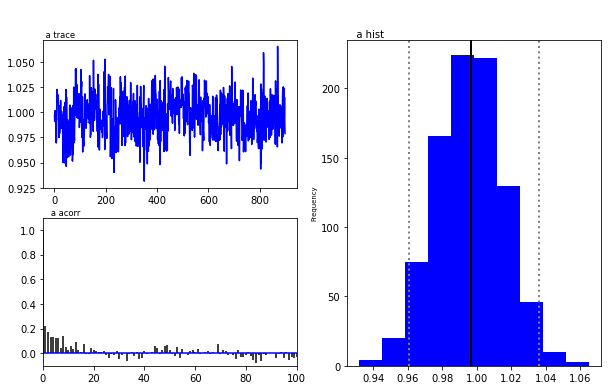

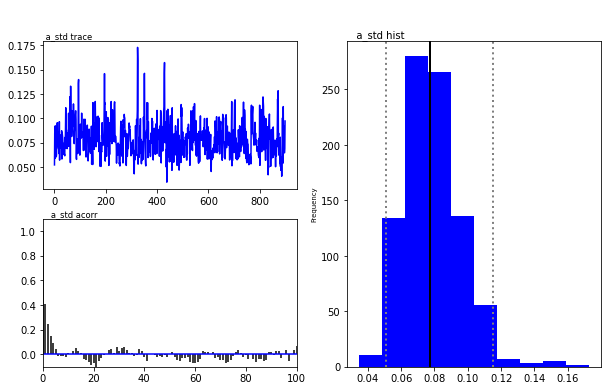

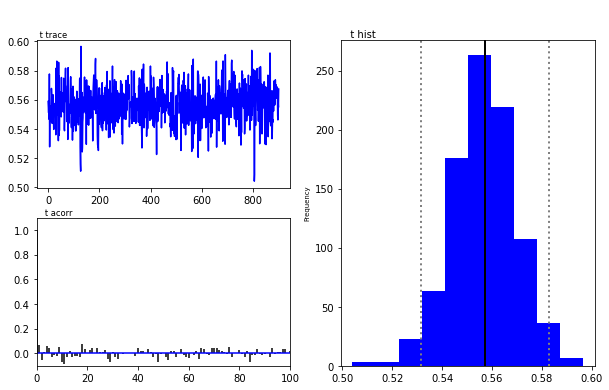

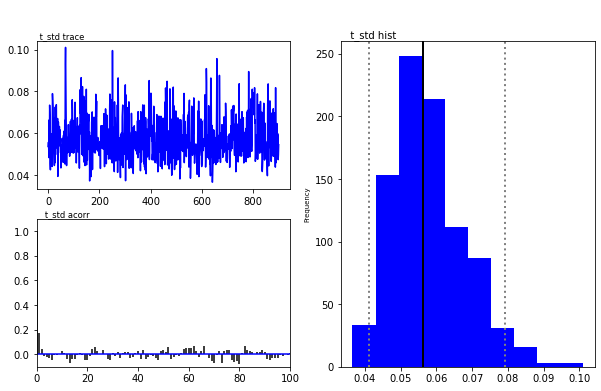

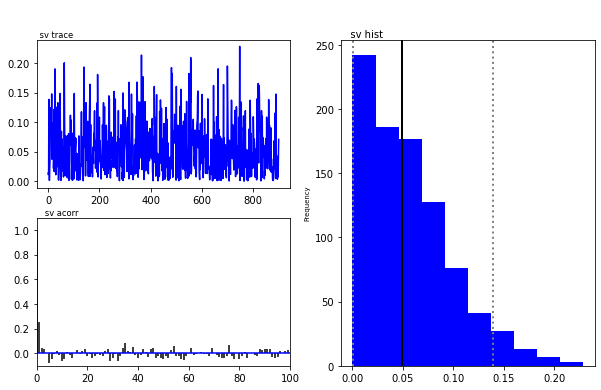

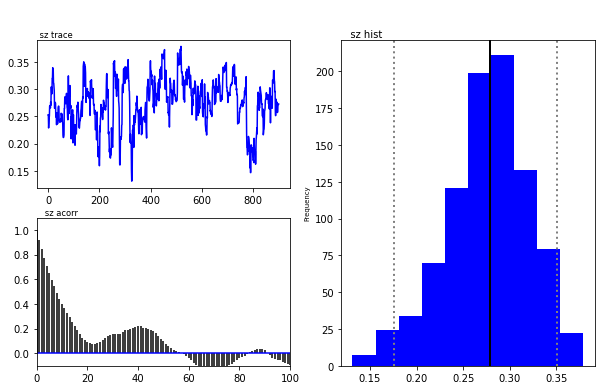

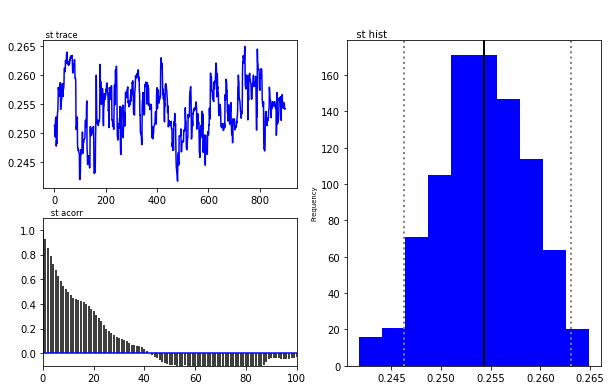

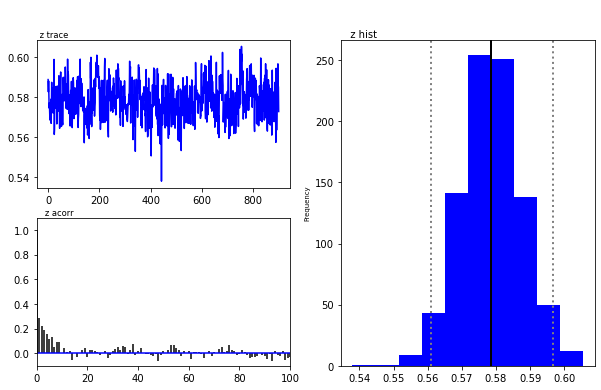

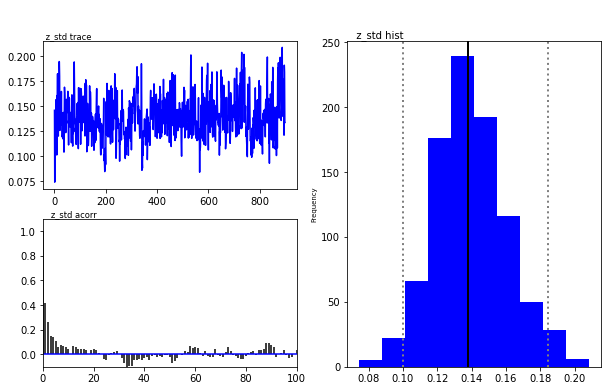

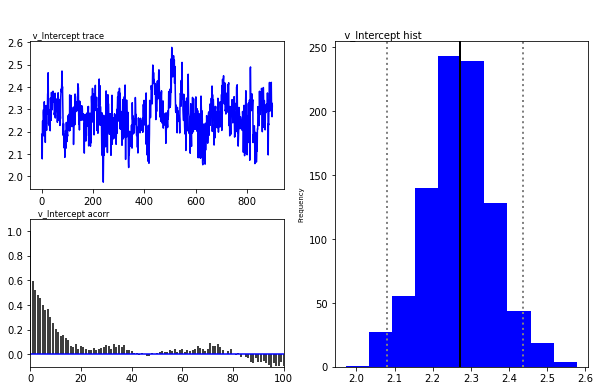

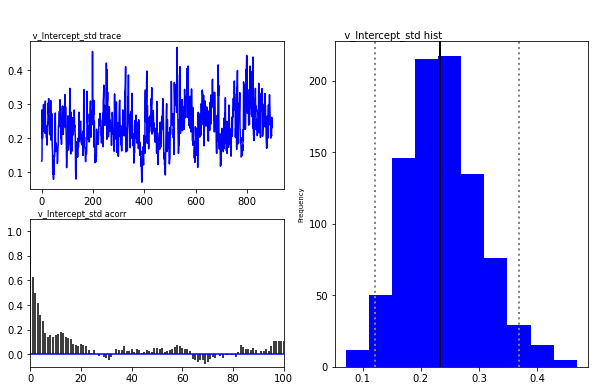

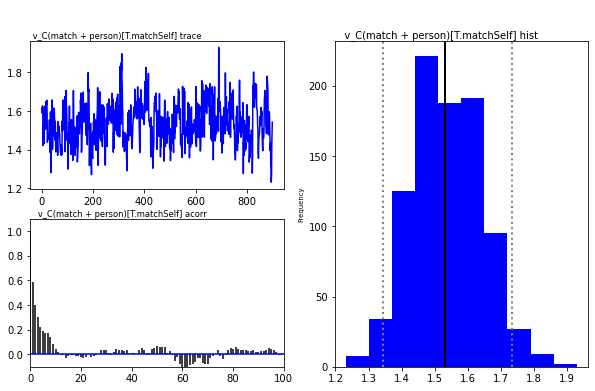

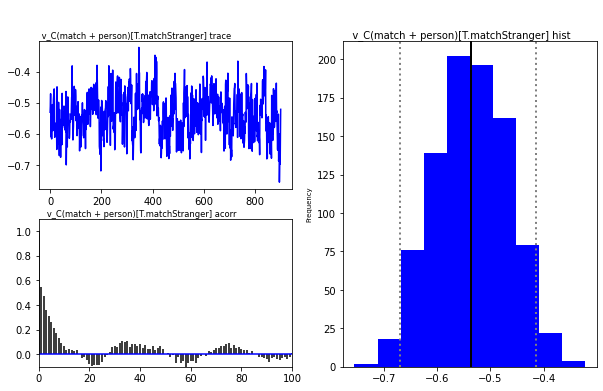

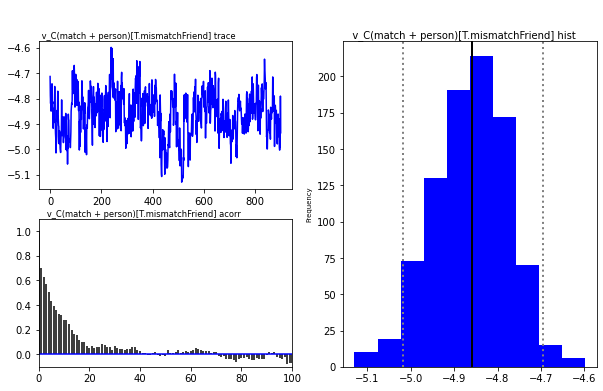

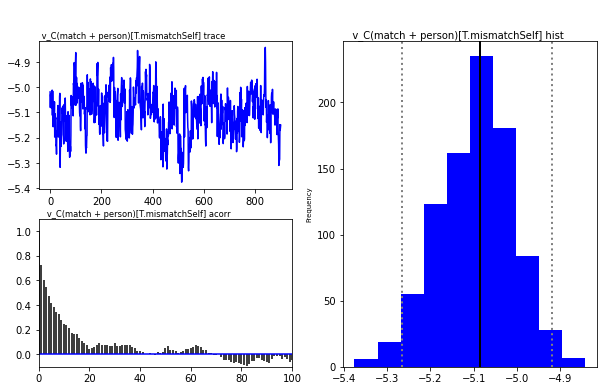

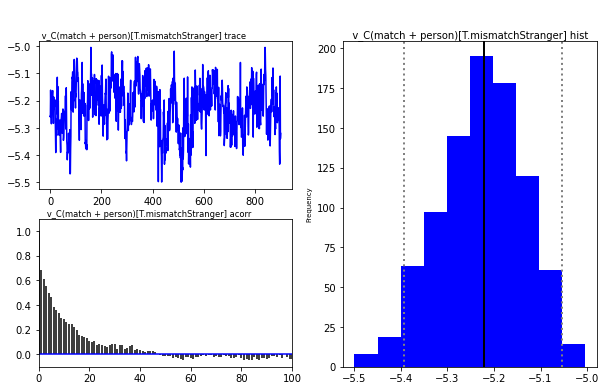

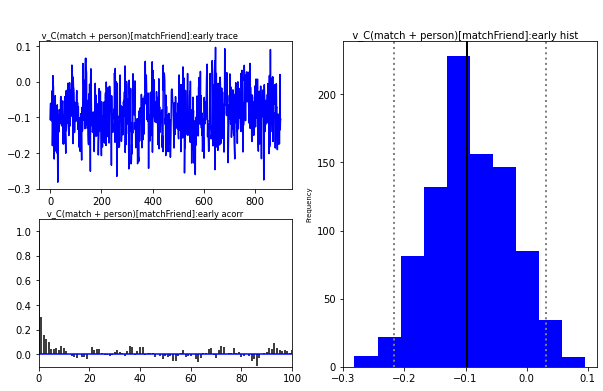

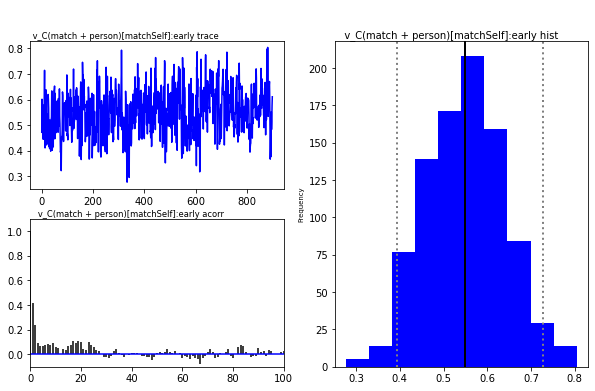

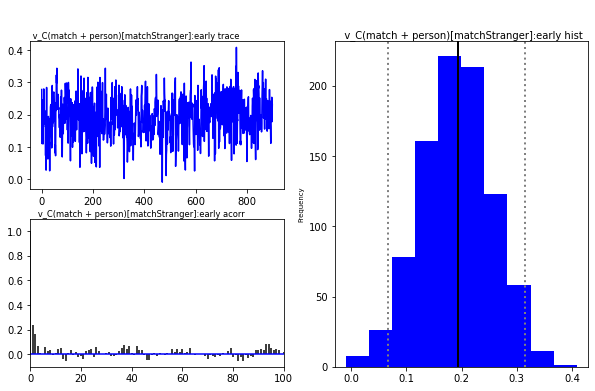

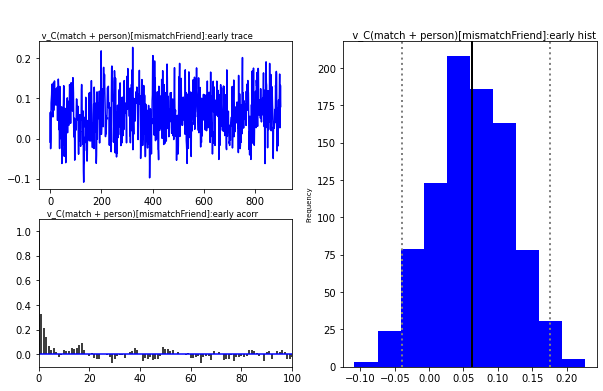

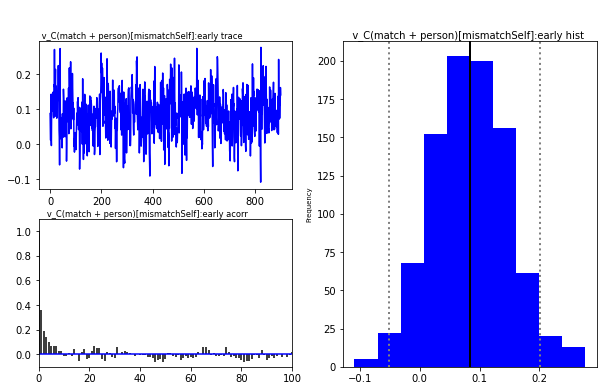

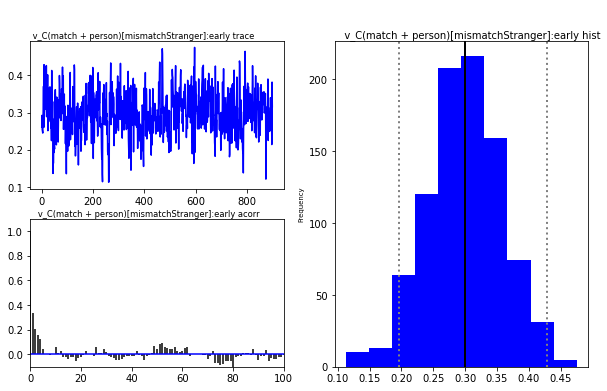

In [18]:
###### convergence check
reg_m4.plot_posteriors()


In [19]:
######################### Model 5: n1: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m5"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):n1', 'link_func': lambda x: x}

reg_m5 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m5.find_starting_values()
reg_m5.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m5.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m5 DIC: %f" %reg_m5.dic) #
reg_m5.print_stats() # check values of reg coefficients against the generated ones



Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:n1', 'v_C(match + person)[matchSelf]:n1', 'v_C(match + person)[matchStranger]:n1', 'v_C(match + person)[mismatchFriend]:n1', 'v_C(match + person)[mismatchSelf]:n1', 'v_C(match + person)[mismatchStranger]:n1']
 [-----------------100%-----------------] 1001 of 1000 complete in 53803.4 secWARNING: Will not save custom link functions.
reg_m5 DIC: -9976.874916
                                                mean         std        2.5q        25q         50q          75q      97.5q       mc err
a                                           0.997888   0.0201035    0.959159    0.98442    0.999188      1.01183    1.03988  0.000870915
a_std                                      0.0796652   0.0164552   0.0543787  0.0688679    0.0

In [ ]:
###### get traces

reg_m5_group_trace = reg_m5.get_group_traces()
reg_m5_trace = reg_m55.get_traces()

reg_m5_group_trace.to_csv('reg_m5_group_traces.csv')
reg_m5_trace.to_csv('reg_m5_traces.csv')

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:n1
Plotting v_C(match + person)[matchSelf]:n1
Plotting v_C(match + person)[matchStranger]:n1
Plotting v_C(match + person)[mismatchFriend]:n1
Plotting v_C(match + person)[mismatchSelf]:n1
Plotting v_C(match + person)[mismatchStranger]:n1


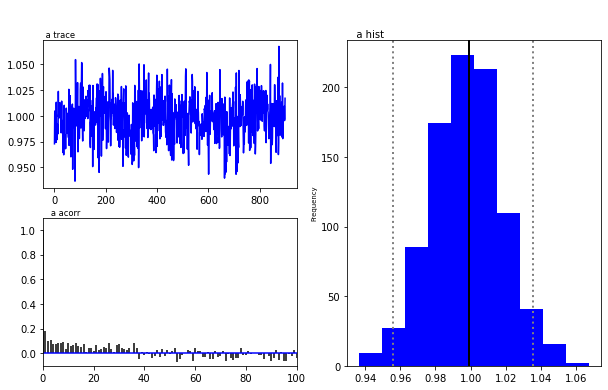

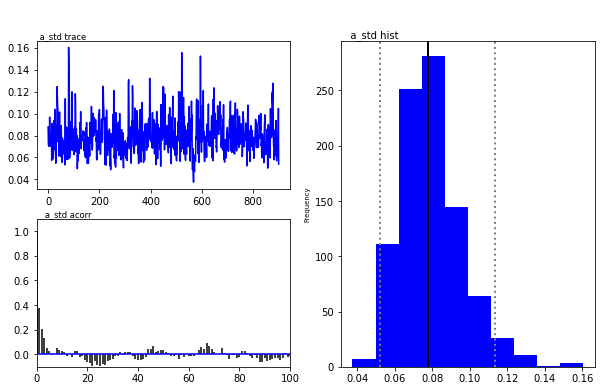

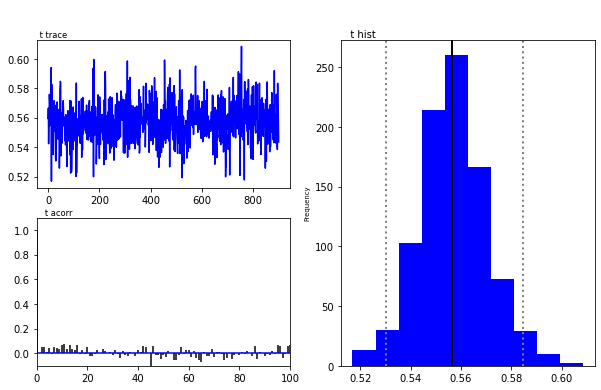

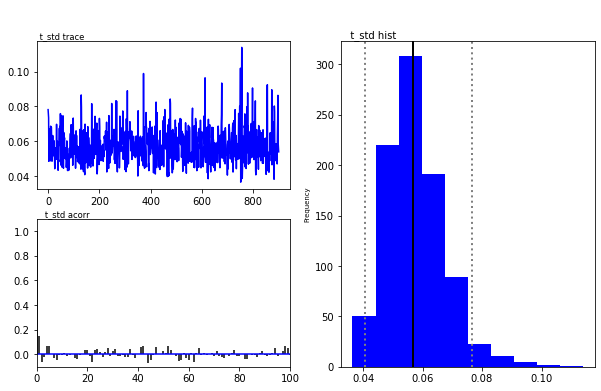

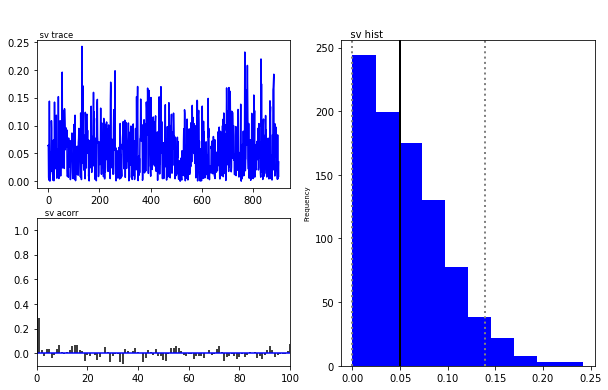

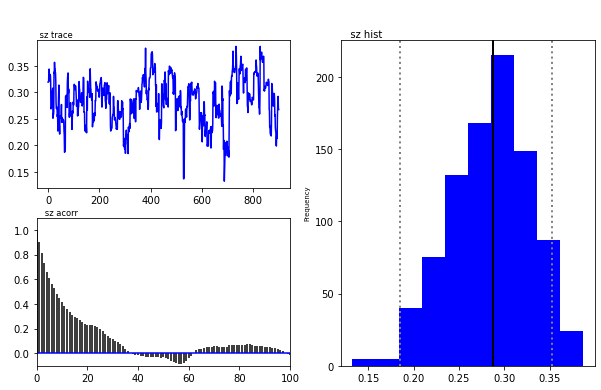

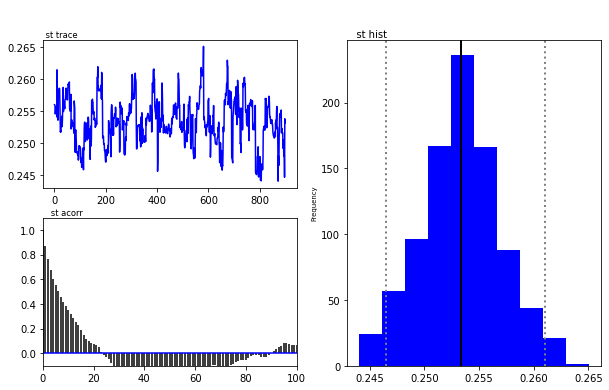

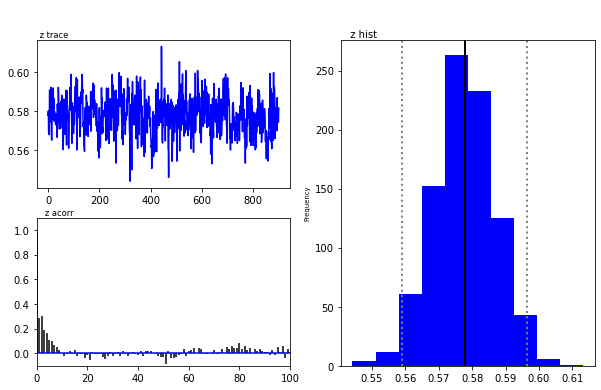

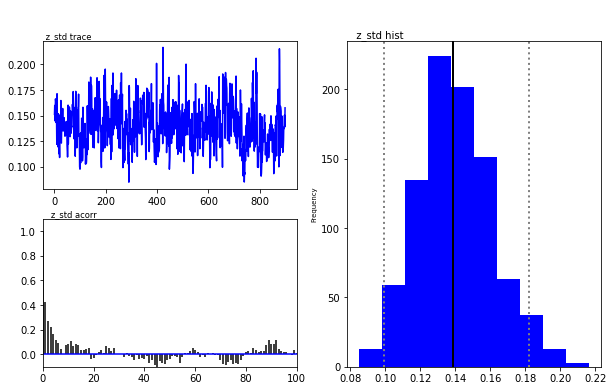

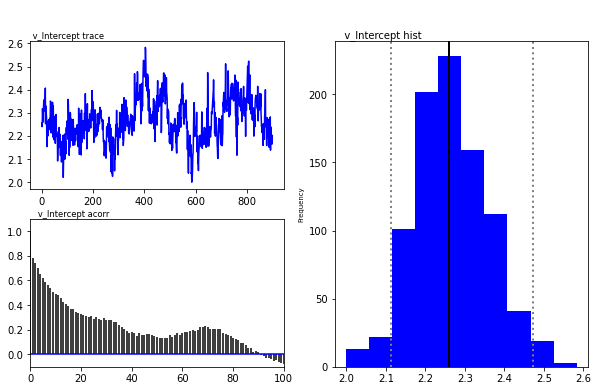

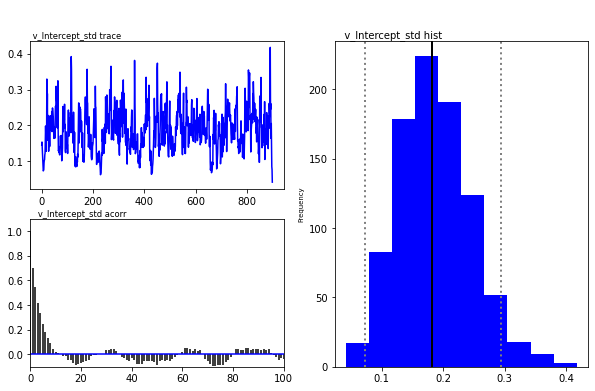

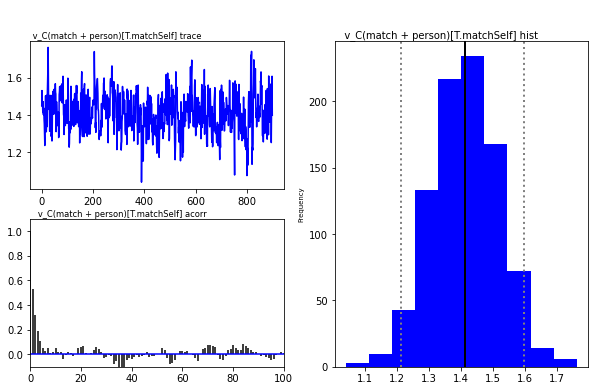

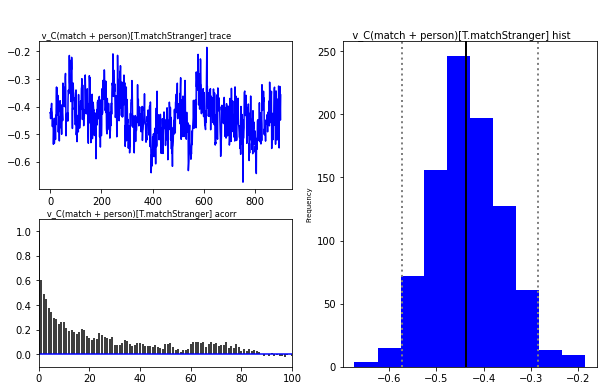

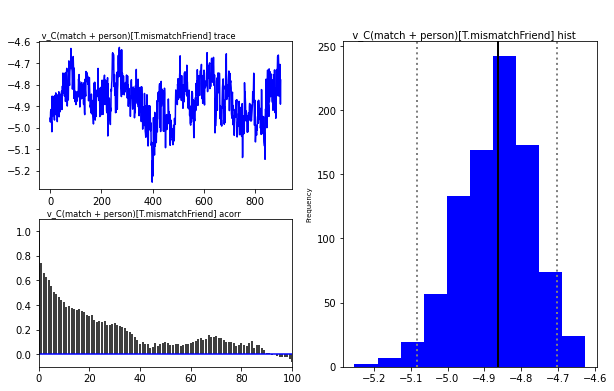

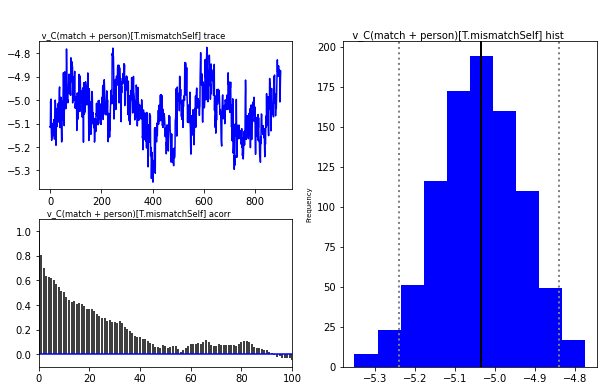

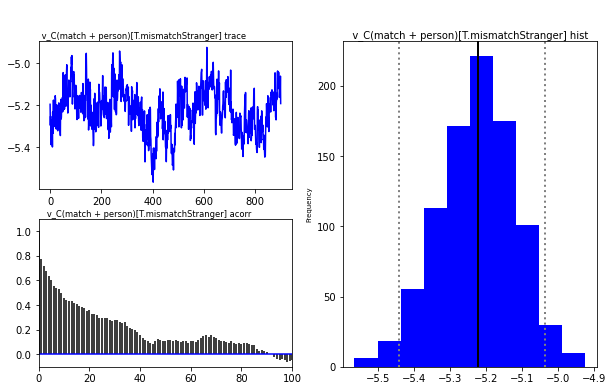

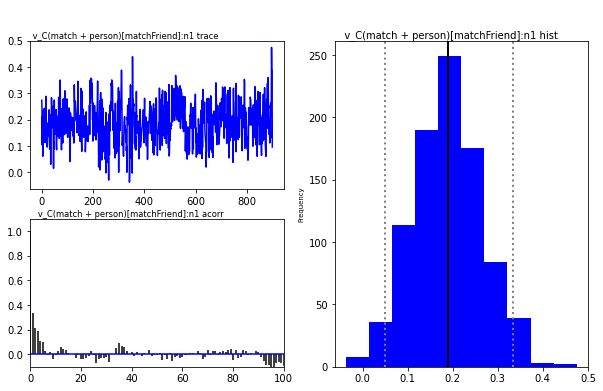

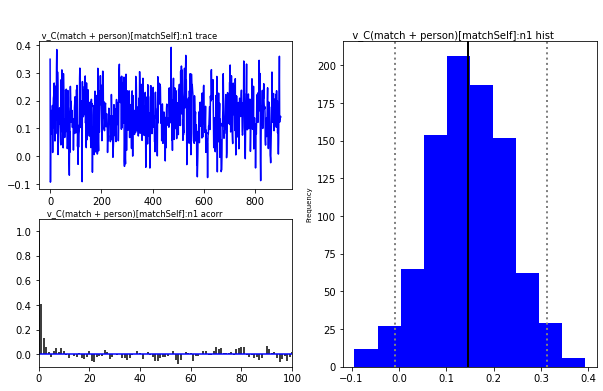

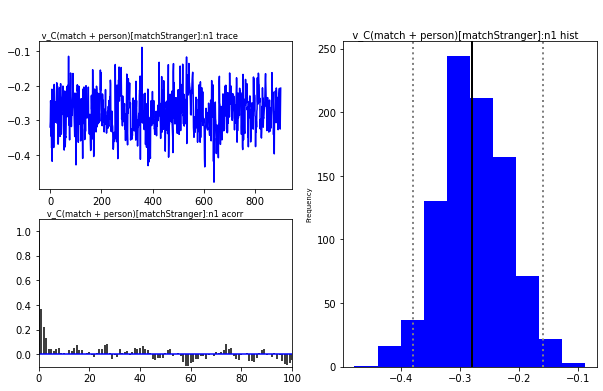

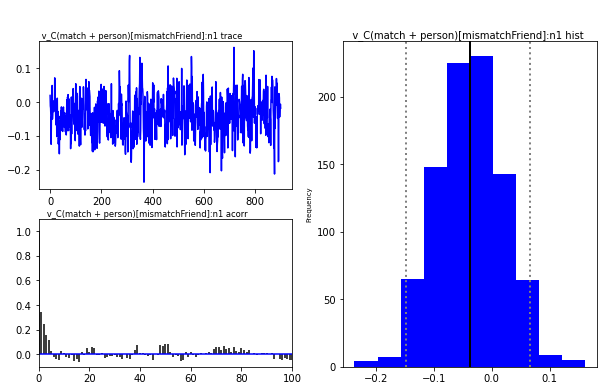

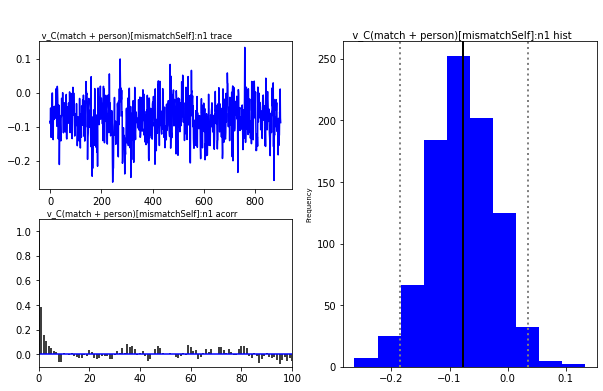

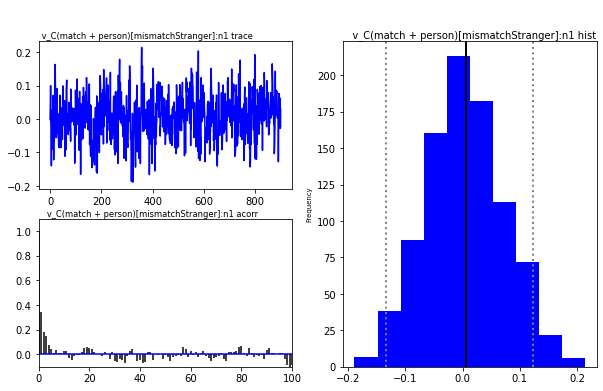

In [21]:
###### convergence check

reg_m5.plot_posteriors()


In [38]:
######################### Model 55: n1_raw: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m55"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):n1_raw', 'link_func': lambda x: x}

reg_m55 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m55.find_starting_values()
reg_m55.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m55.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m55 DIC: %f" %reg_m55.dic) #
reg_m55.print_stats() # check values of reg coefficients against the generated ones



Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:n1_raw', 'v_C(match + person)[matchSelf]:n1_raw', 'v_C(match + person)[matchStranger]:n1_raw', 'v_C(match + person)[mismatchFriend]:n1_raw', 'v_C(match + person)[mismatchSelf]:n1_raw', 'v_C(match + person)[mismatchStranger]:n1_raw']
 [-----------------100%-----------------] 1001 of 1000 complete in 32468.8 secWARNING: Will not save custom link functions.
reg_m55 DIC: -9969.398786
                                                    mean         std        2.5q        25q         50q         75q      97.5q       mc err
a                                               0.996389   0.0200238    0.958416   0.983121    0.995907      1.0095    1.03526  0.000843887
a_std                                            0.07949   0.01

In [40]:
###### get traces

reg_m55_group_trace = reg_m55.get_group_traces()
reg_m55_trace = reg_m55.get_traces()

reg_m55_group_trace.to_csv('reg_m55_group_traces.csv')
reg_m55_trace.to_csv('reg_m55_traces.csv')

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:n1_raw
Plotting v_C(match + person)[matchSelf]:n1_raw
Plotting v_C(match + person)[matchStranger]:n1_raw
Plotting v_C(match + person)[mismatchFriend]:n1_raw
Plotting v_C(match + person)[mismatchSelf]:n1_raw
Plotting v_C(match + person)[mismatchStranger]:n1_raw


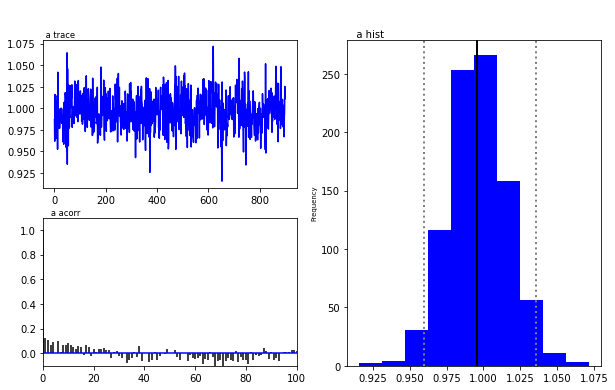

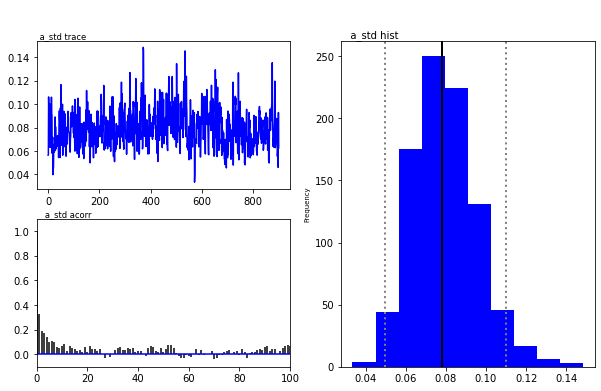

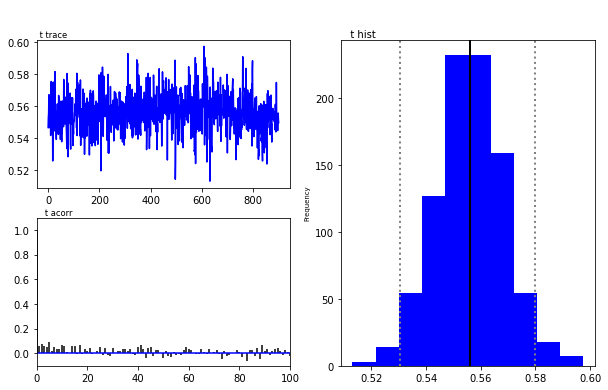

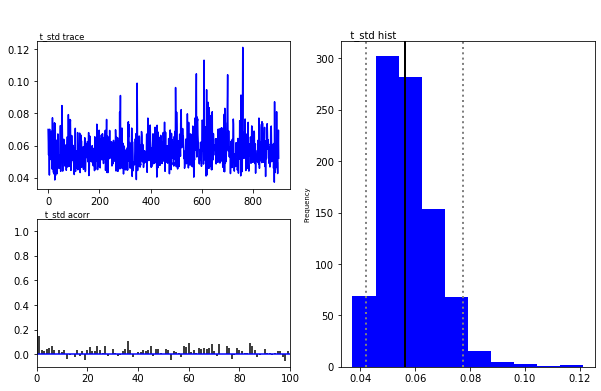

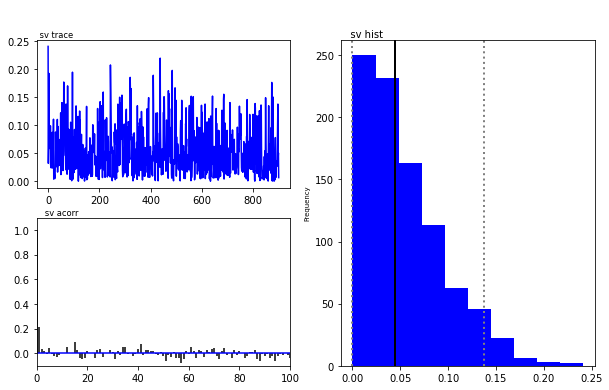

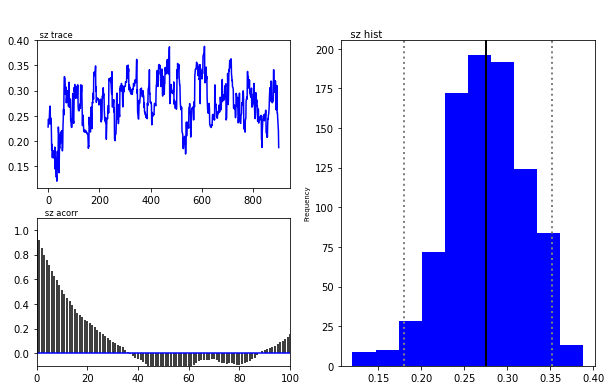

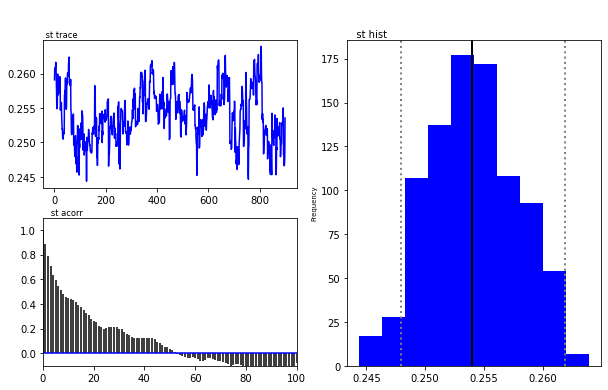

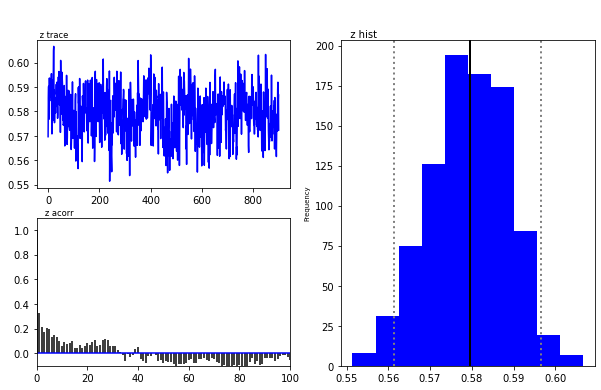

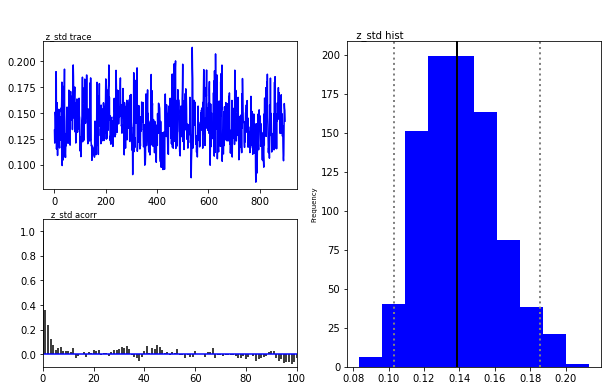

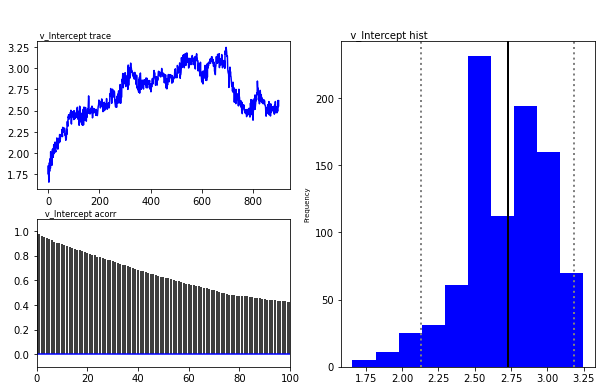

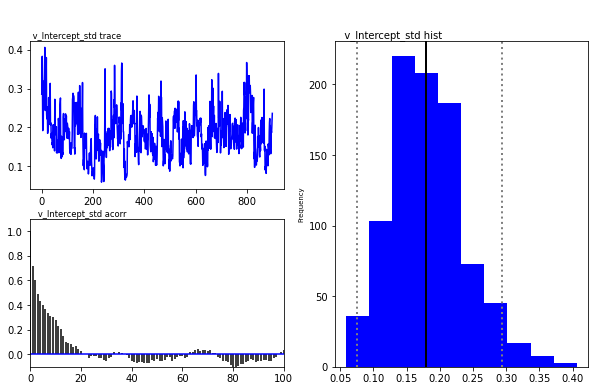

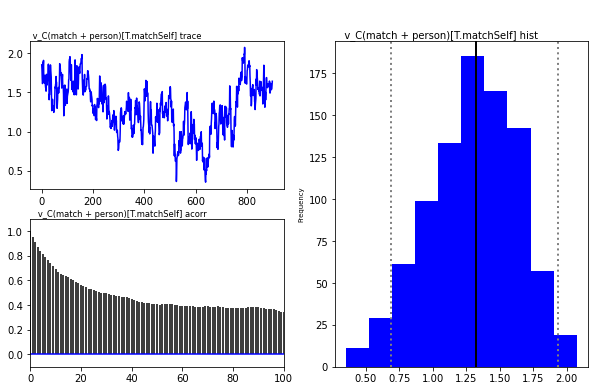

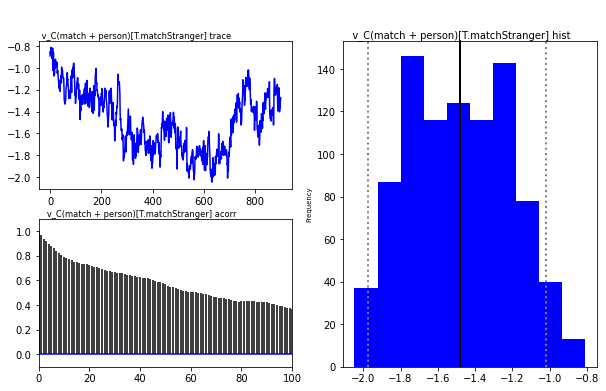

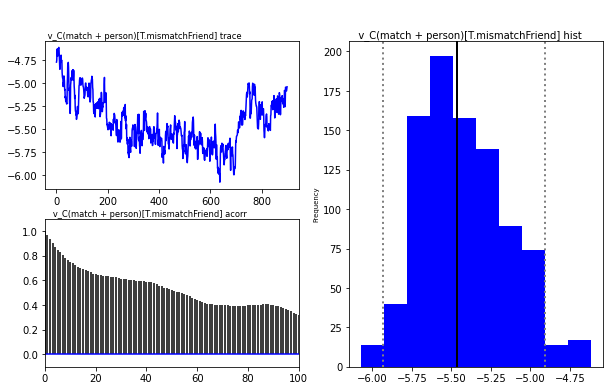

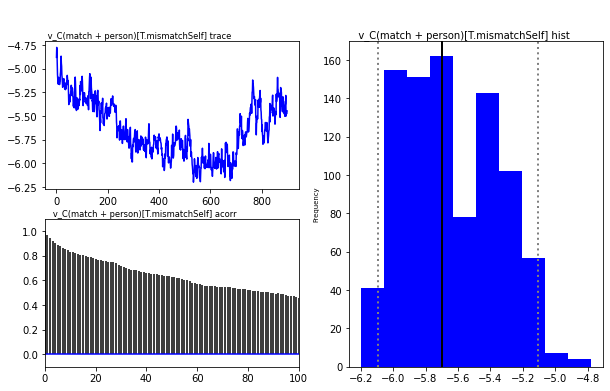

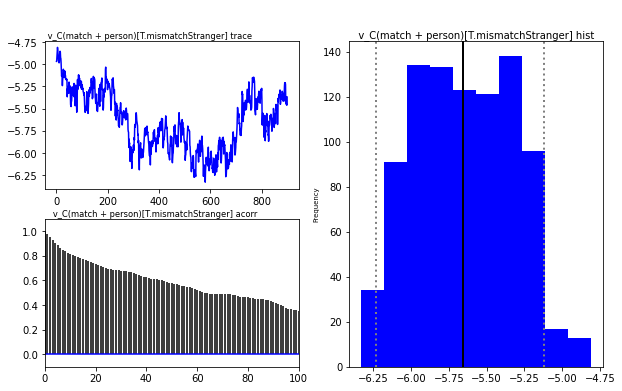

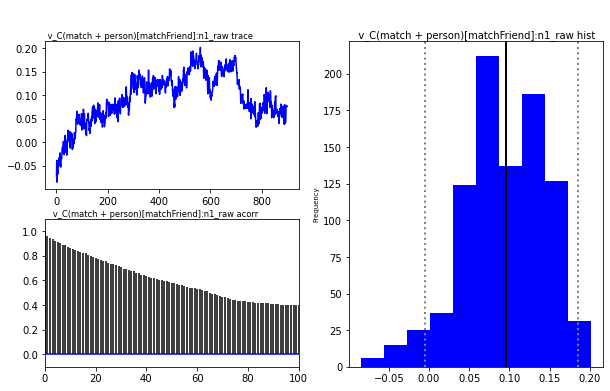

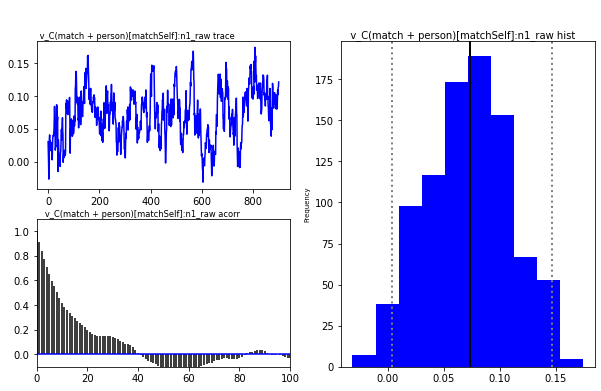

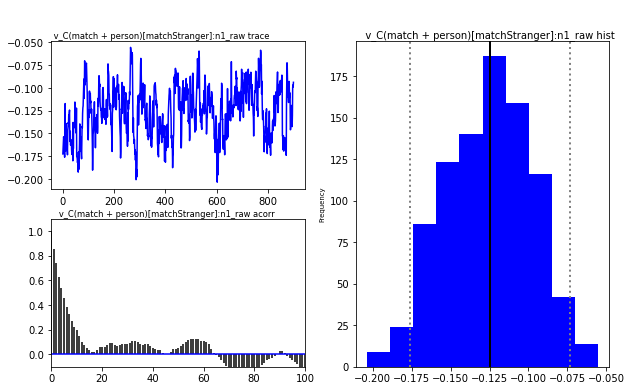

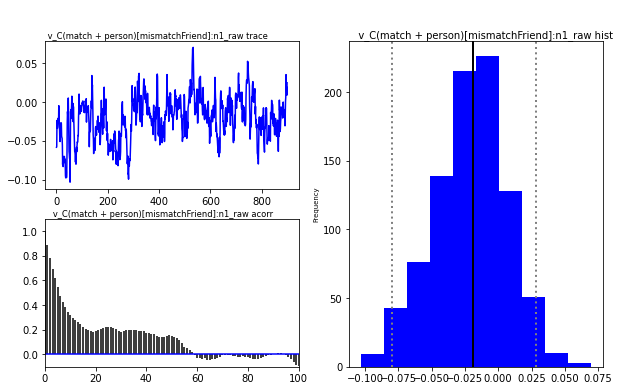

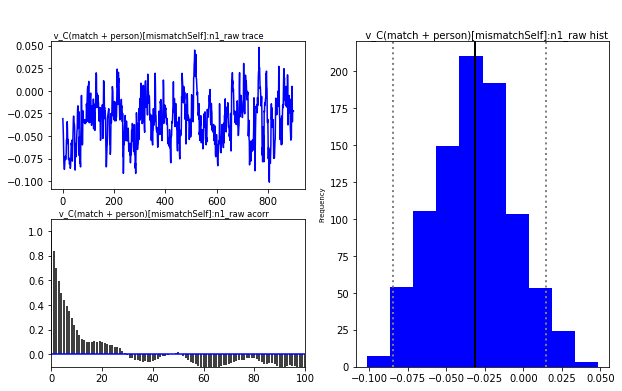

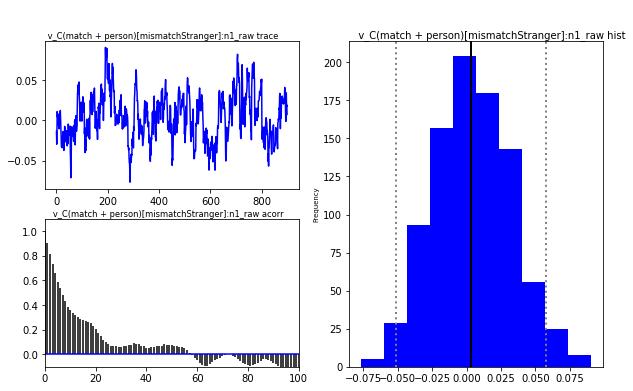

In [41]:
###### convergence check

reg_m55.plot_posteriors()


In [22]:
######################### Model 6: p3: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m6"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):p3', 'link_func': lambda x: x}

reg_m6 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m6.find_starting_values()
reg_m6.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m6.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m6 DIC: %f" %reg_m6.dic) #
reg_m6.print_stats() # check values of reg coefficients against the generated ones



Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:p3', 'v_C(match + person)[matchSelf]:p3', 'v_C(match + person)[matchStranger]:p3', 'v_C(match + person)[mismatchFriend]:p3', 'v_C(match + person)[mismatchSelf]:p3', 'v_C(match + person)[mismatchStranger]:p3']
 [-----------------100%-----------------] 1001 of 1000 complete in 44953.1 secWARNING: Will not save custom link functions.
reg_m6 DIC: -9987.238519
                                               mean         std        2.5q        25q        50q        75q       97.5q       mc err
a                                           1.00006   0.0225731    0.958305   0.984872   0.999257    1.01464      1.0432   0.00109425
a_std                                     0.0823771   0.0172463   0.0552621  0.0701023  0.0798231   

In [ ]:
###### get traces

reg_m6_group_trace = reg_m6.get_group_traces()
reg_m6_trace = reg_m6.get_traces()

reg_m6_group_trace.to_csv('reg_m6_group_traces.csv')
reg_m6_trace.to_csv('reg_m6_traces.csv')

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:p3
Plotting v_C(match + person)[matchSelf]:p3
Plotting v_C(match + person)[matchStranger]:p3
Plotting v_C(match + person)[mismatchFriend]:p3
Plotting v_C(match + person)[mismatchSelf]:p3
Plotting v_C(match + person)[mismatchStranger]:p3


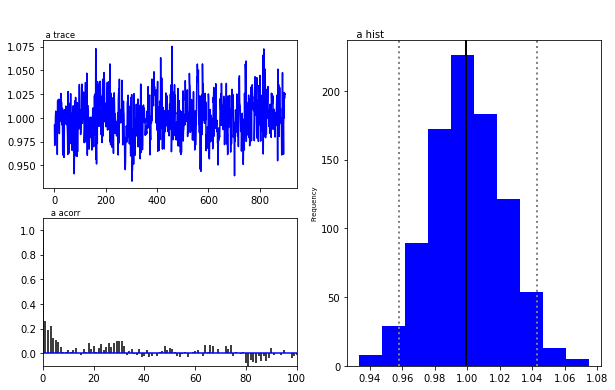

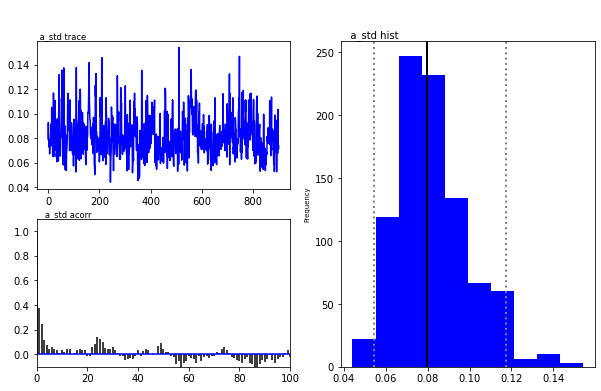

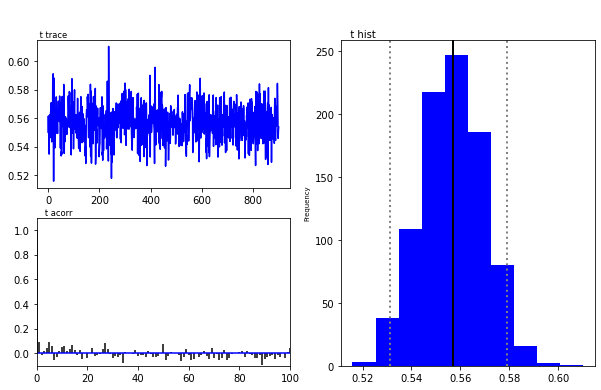

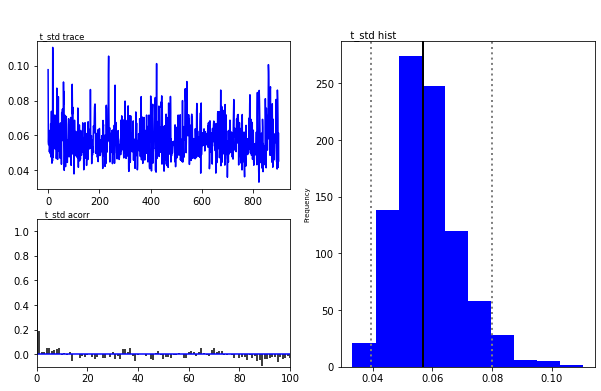

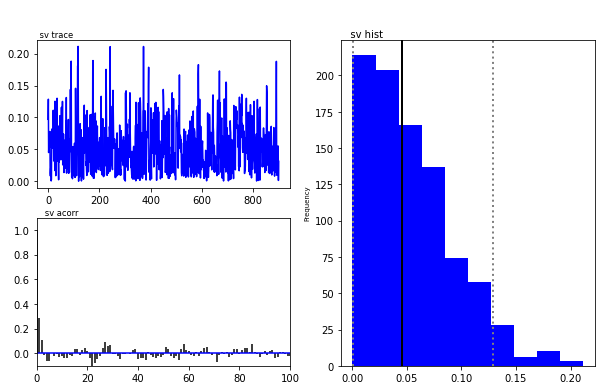

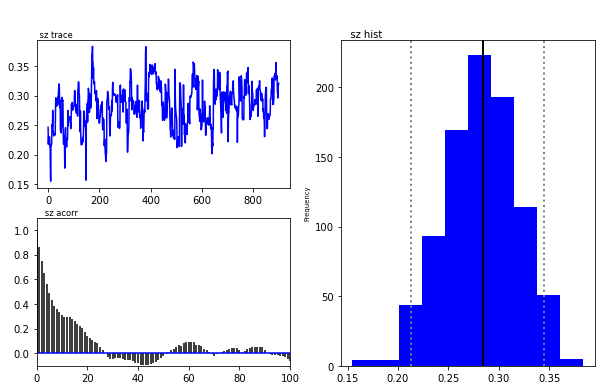

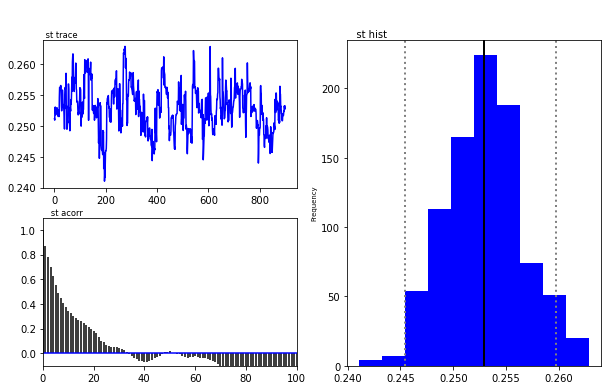

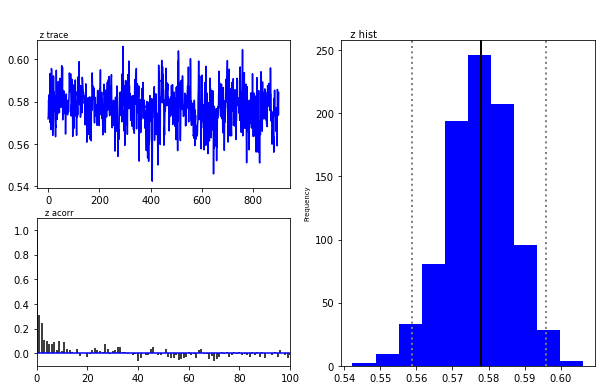

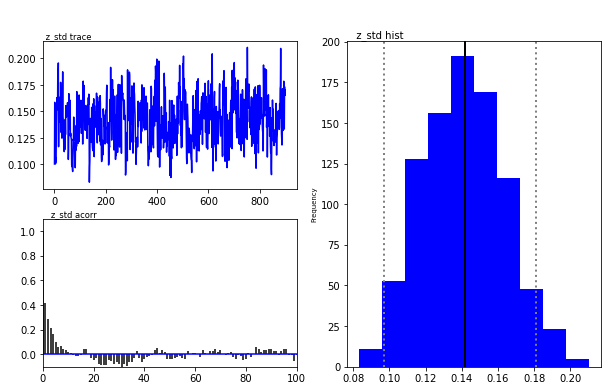

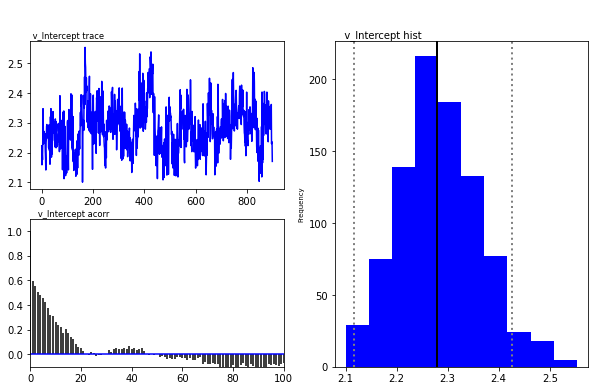

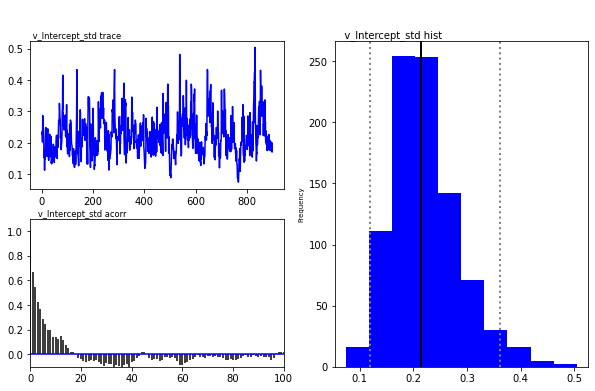

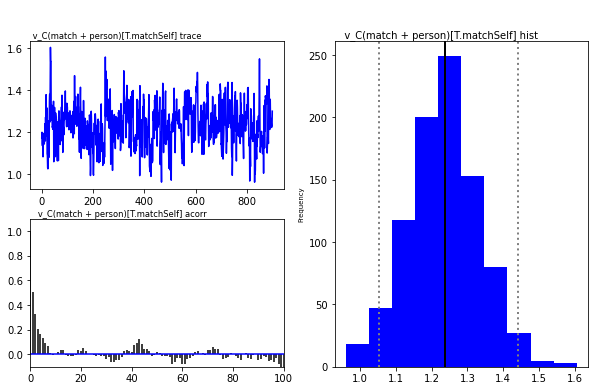

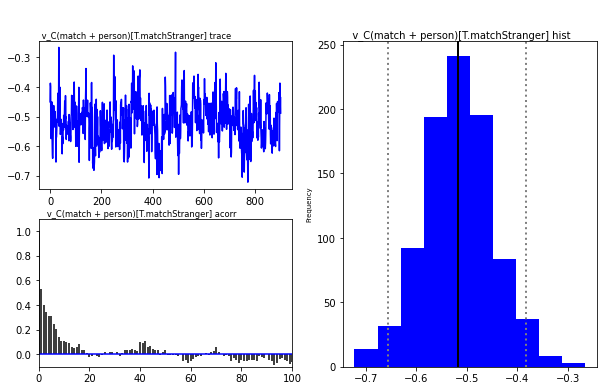

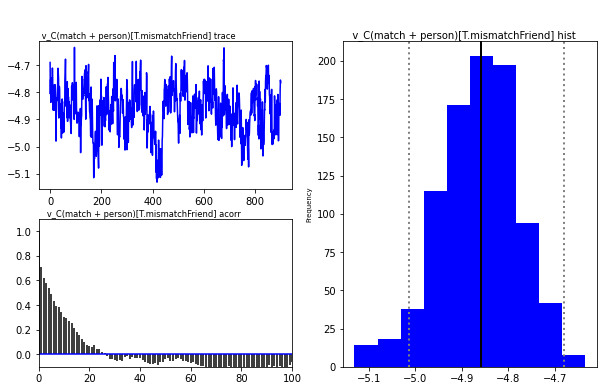

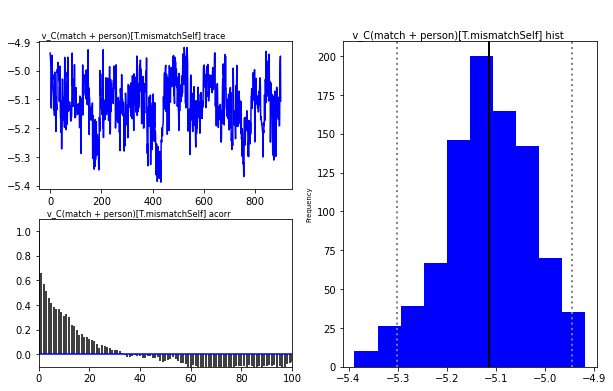

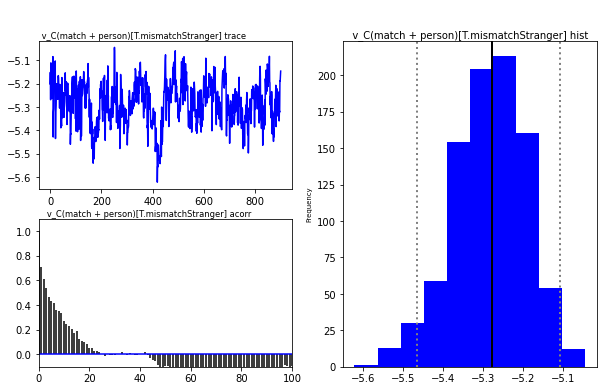

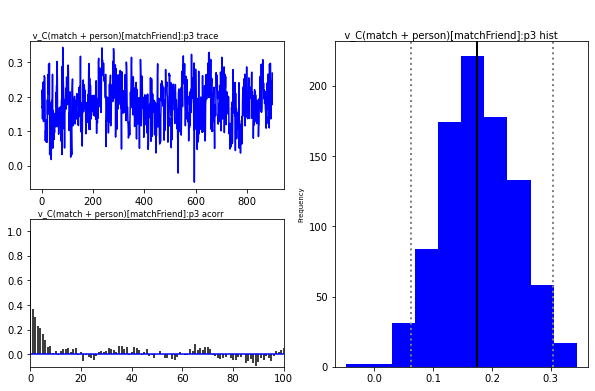

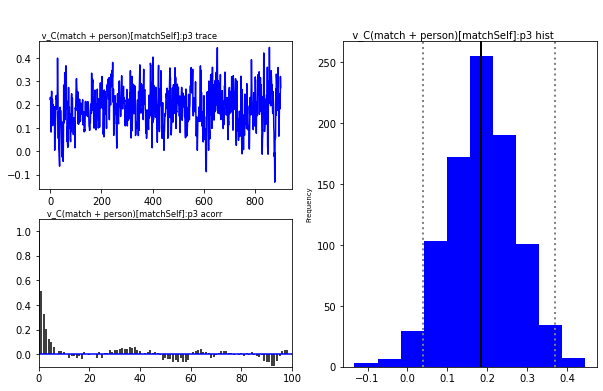

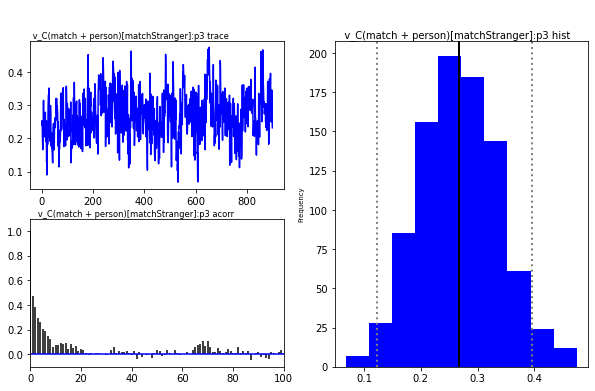

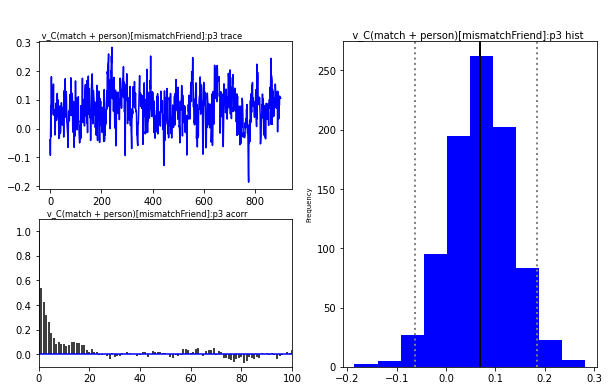

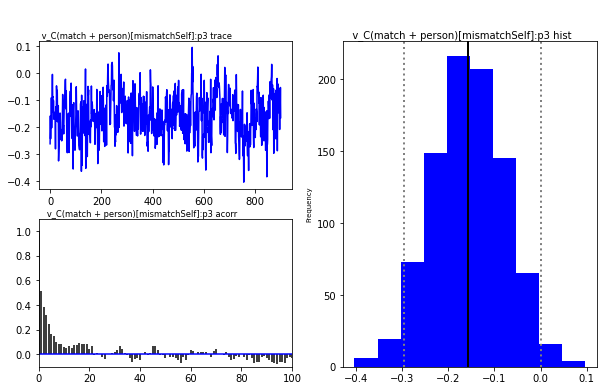

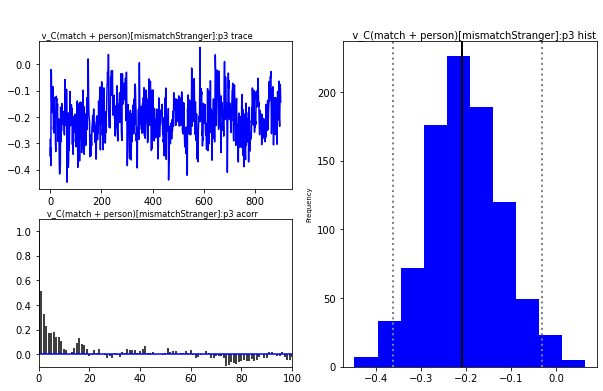

In [24]:
###### convergence check

reg_m6.plot_posteriors()


In [ ]:
######################### Model 66: p3_raw: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m66"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):p3_raw', 'link_func': lambda x: x}

reg_m66 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m66.find_starting_values()
reg_m66.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m66.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m66 DIC: %f" %reg_m66.dic) #
reg_m66.print_stats() # check values of reg coefficients against the generated ones

In [ ]:
###### get traces

reg_m66_group_trace = reg_m66.get_group_traces()
reg_m66_trace = reg_m66.get_traces()

reg_m66_group_trace.to_csv('reg_m66_group_traces.csv')
reg_m66_trace.to_csv('reg_m66_traces.csv')

In [ ]:
###### convergence check

reg_m66.plot_posteriors()


In [43]:
######################### Model 7: alpha: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m7"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):alpha', 'link_func': lambda x: x}

reg_m7 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m7.find_starting_values()
reg_m7.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m7.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m7 DIC: %f" %reg_m7.dic) #
reg_m7.print_stats() # check values of reg coefficients against the generated ones


Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:alpha', 'v_C(match + person)[matchSelf]:alpha', 'v_C(match + person)[matchStranger]:alpha', 'v_C(match + person)[mismatchFriend]:alpha', 'v_C(match + person)[mismatchSelf]:alpha', 'v_C(match + person)[mismatchStranger]:alpha']
 [-                 4%                  ] 45 of 1000 complete in 2675.1 secHalting at iteration  44  of  1000
Could not generate output statistics for z_subj_trans.19
Could not generate output statistics for z_subj.6
Could not generate output statistics for t_subj.14
Could not generate output statistics for sz
Could not generate output statistics for z_subj_trans.12
Could not generate output statistics for v_C(match + person)[T.mismatchSelf]
Could not generate output statistics for v_Intercept_

TypeError: 'NoneType' object is not subscriptable

In [ ]:
###### get traces

reg_m7_group_trace = reg_m7.get_group_traces()
reg_m7_trace = reg_m7.get_traces()

reg_m7_group_trace.to_csv('reg_m7_group_traces.csv')
reg_m7_trace.to_csv('reg_m7_traces.csv')

In [ ]:
###### convergence check

reg_m7.plot_posteriors()

In [44]:
######################### Model 8: gammal: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m8"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):gammal', 'link_func': lambda x: x}

reg_m8 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m8.find_starting_values()
reg_m8.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m8.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m8 DIC: %f" %reg_m8.dic) #
reg_m8.print_stats() # check values of reg coefficients against the generated ones

Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:gammal', 'v_C(match + person)[matchSelf]:gammal', 'v_C(match + person)[matchStranger]:gammal', 'v_C(match + person)[mismatchFriend]:gammal', 'v_C(match + person)[mismatchSelf]:gammal', 'v_C(match + person)[mismatchStranger]:gammal']
 [-----------------100%-----------------] 1001 of 1000 complete in 95597.7 secWARNING: Will not save custom link functions.
reg_m8 DIC: -10091.948519
                                                   mean         std        2.5q        25q        50q        75q      97.5q       mc err
a                                               1.00254   0.0204948    0.963443   0.988991    1.00171    1.01561    1.04302   0.00113953
a_std                                         0.0784996   0.0159133  

In [45]:
###### get traces

reg_m8_group_trace = reg_m8.get_group_traces()
reg_m8_trace = reg_m8.get_traces()

reg_m8_group_trace.to_csv('reg_m8_group_traces.csv')
reg_m8_trace.to_csv('reg_m8_traces.csv')


Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:gammal
Plotting v_C(match + person)[matchSelf]:gammal
Plotting v_C(match + person)[matchStranger]:gammal
Plotting v_C(match + person)[mismatchFriend]:gammal
Plotting v_C(match + person)[mismatchSelf]:gammal
Plotting v_C(match + person)[mismatchStranger]:gammal


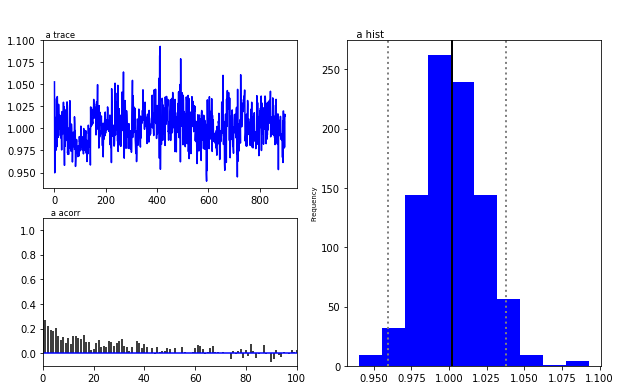

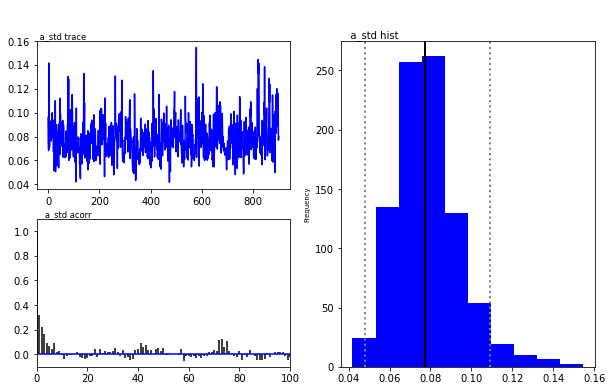

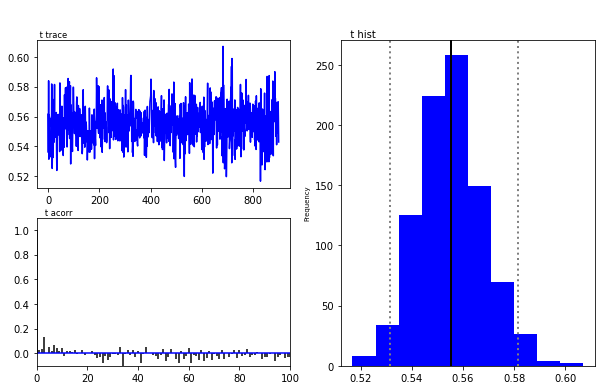

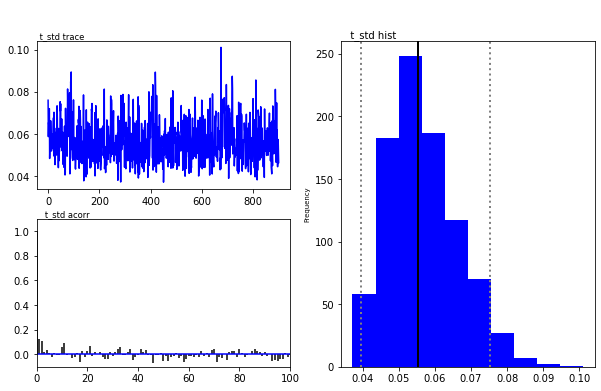

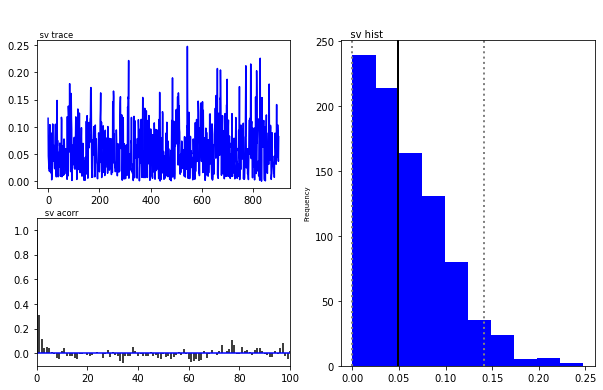

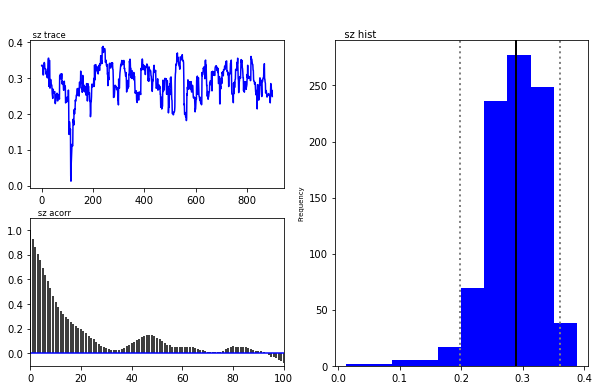

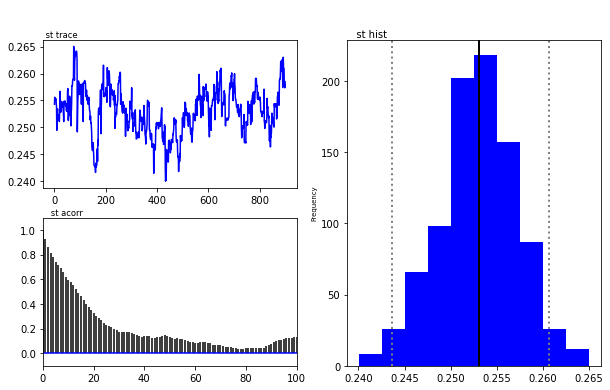

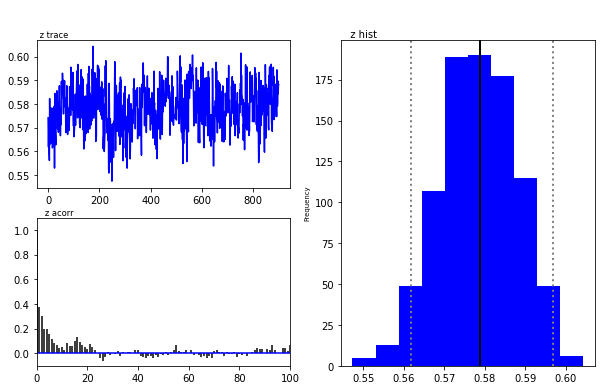

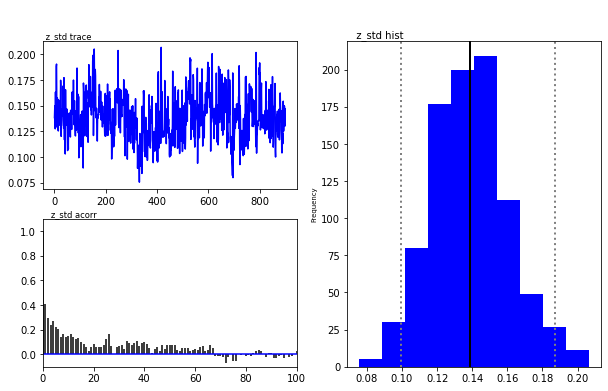

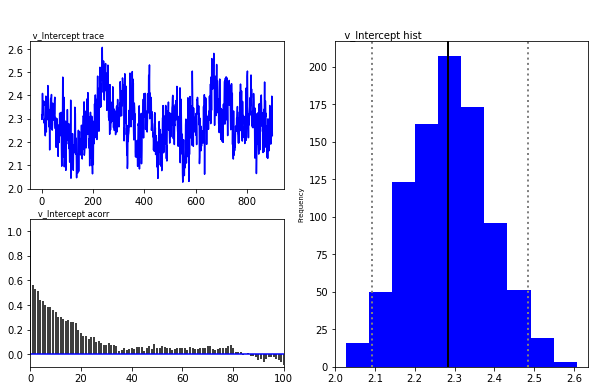

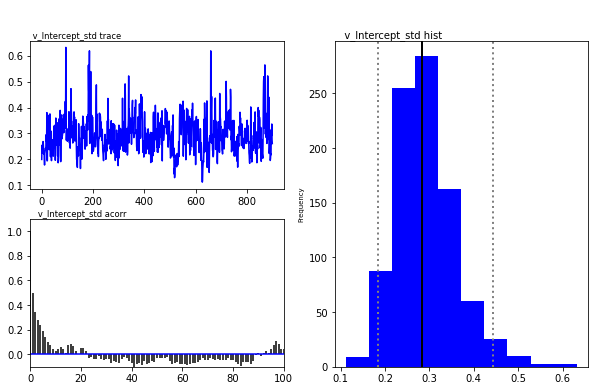

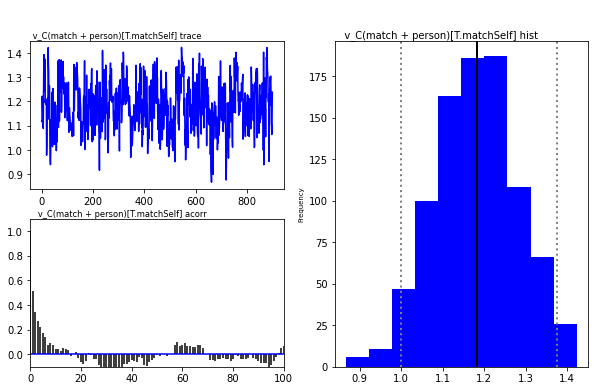

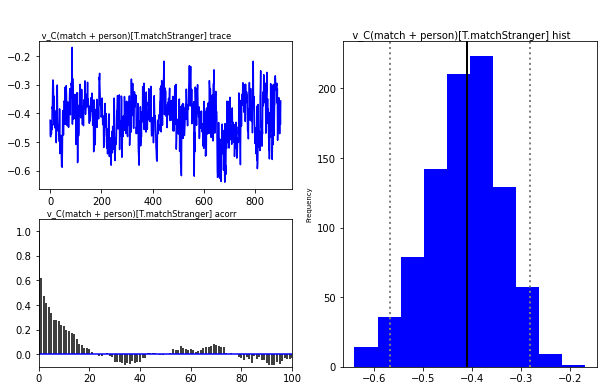

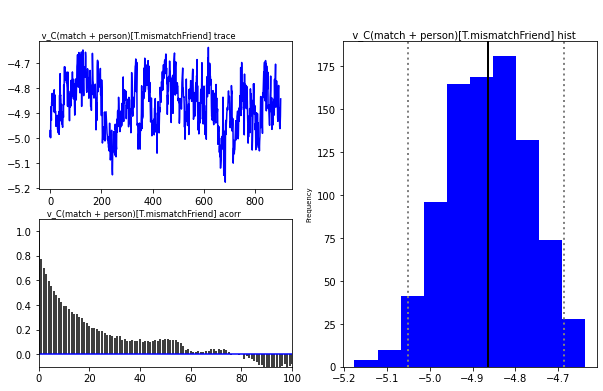

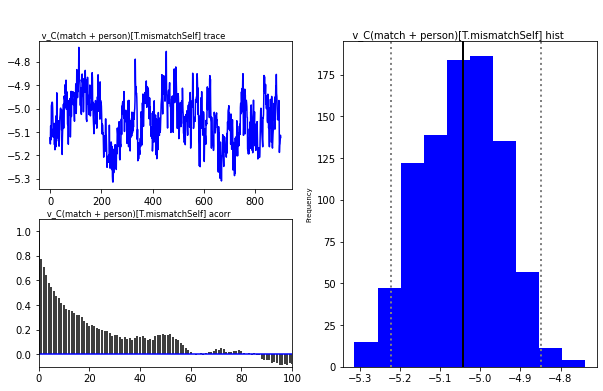

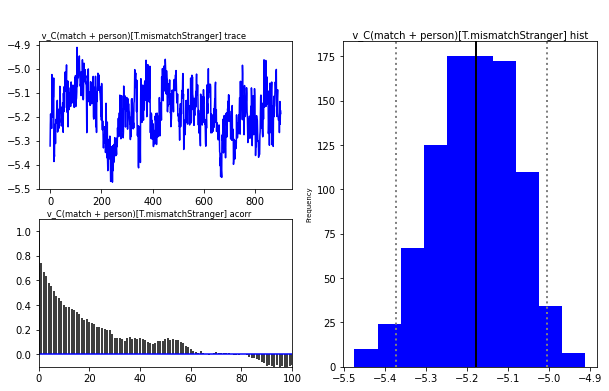

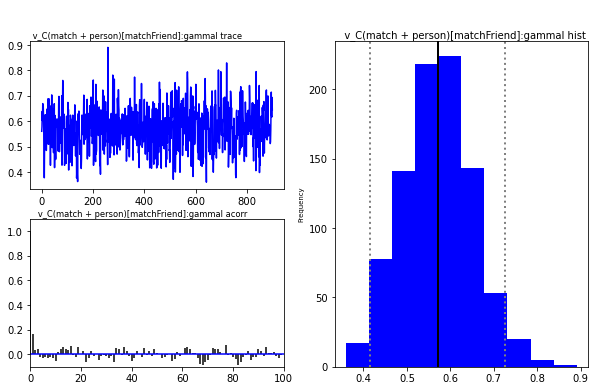

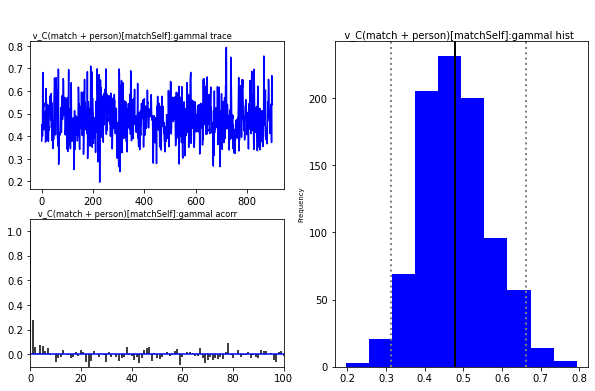

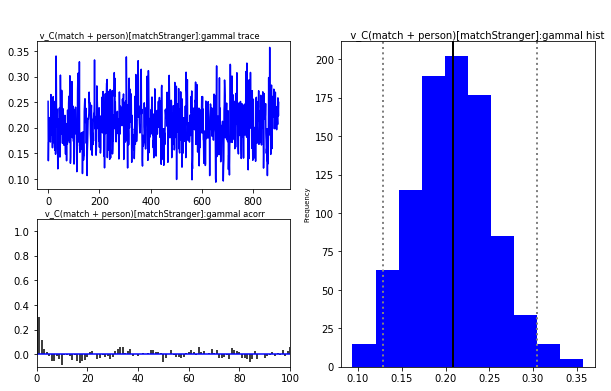

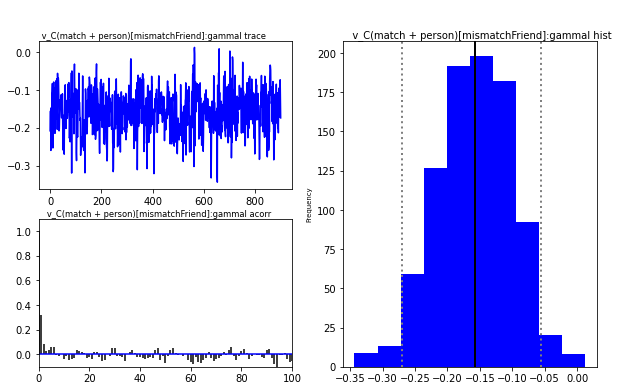

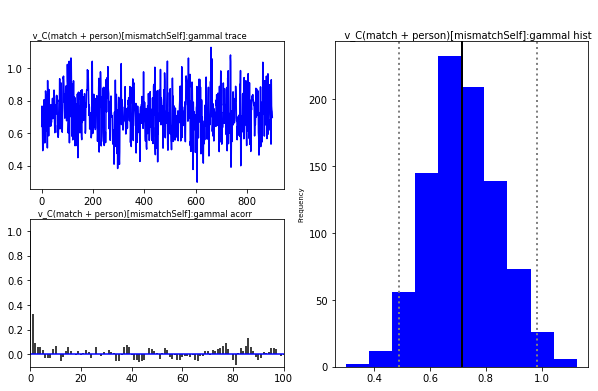

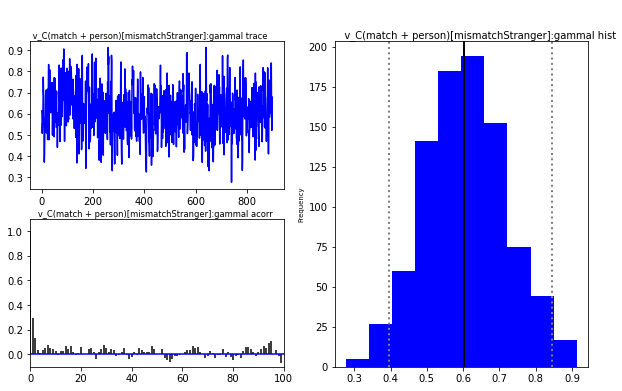

In [46]:
###### convergence check

reg_m8.plot_posteriors()

In [47]:
######################### Model 9: gammah: v ############################################################

start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')
dbname = "reg_m9"

v_reg = {'model': 'v ~1 + C(match + person) + C(match + person):gammah', 'link_func': lambda x: x}

reg_m9 = hddm.HDDMRegressor(dat_M_match, v_reg,                                
                                    include=('z', 'sv', 'sz', 'st'), group_only_regressors=True) 
               
reg_m9.find_starting_values()
reg_m9.sample(1000, burn=100, dbname='v_bwsubs_int.db', db='pickle')

# save the model
reg_m9.save(dbname)

## ppc_data_match_m1 = hddm.utils.post_pred_gen(M_match_m1)
## ppc_compare_match_m1 = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_m1)  # MSE 
## ppc_compare_match_m1.to_csv('ppc_compare_match_m1.csv', sep = ',')

print("reg_m9 DIC: %f" %reg_m9.dic) #
reg_m9.print_stats() # check values of reg coefficients against the generated ones


Adding these covariates:
['v_Intercept', 'v_C(match + person)[T.matchSelf]', 'v_C(match + person)[T.matchStranger]', 'v_C(match + person)[T.mismatchFriend]', 'v_C(match + person)[T.mismatchSelf]', 'v_C(match + person)[T.mismatchStranger]', 'v_C(match + person)[matchFriend]:gammah', 'v_C(match + person)[matchSelf]:gammah', 'v_C(match + person)[matchStranger]:gammah', 'v_C(match + person)[mismatchFriend]:gammah', 'v_C(match + person)[mismatchSelf]:gammah', 'v_C(match + person)[mismatchStranger]:gammah']
 [-----------------100%-----------------] 1001 of 1000 complete in 86293.0 secWARNING: Will not save custom link functions.
reg_m9 DIC: -9956.413513
                                                   mean         std        2.5q        25q        50q        75q      97.5q       mc err
a                                              0.997505   0.0204837    0.956783   0.984205   0.998353    1.01068    1.03725   0.00109341
a_std                                         0.0779573   0.0164215   

In [48]:
###### get traces

reg_m9_group_trace = reg_m9.get_group_traces()
reg_m9_trace = reg_m9.get_traces()

reg_m9_group_trace.to_csv('reg_m9_group_traces.csv')
reg_m9_trace.to_csv('reg_m9_traces.csv')


Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match + person)[T.matchSelf]
Plotting v_C(match + person)[T.matchStranger]
Plotting v_C(match + person)[T.mismatchFriend]
Plotting v_C(match + person)[T.mismatchSelf]
Plotting v_C(match + person)[T.mismatchStranger]
Plotting v_C(match + person)[matchFriend]:gammah
Plotting v_C(match + person)[matchSelf]:gammah
Plotting v_C(match + person)[matchStranger]:gammah
Plotting v_C(match + person)[mismatchFriend]:gammah
Plotting v_C(match + person)[mismatchSelf]:gammah
Plotting v_C(match + person)[mismatchStranger]:gammah


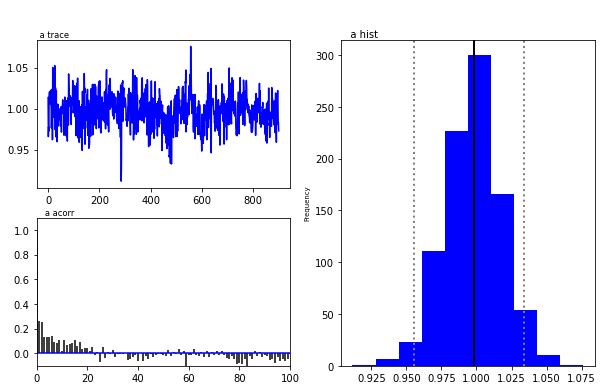

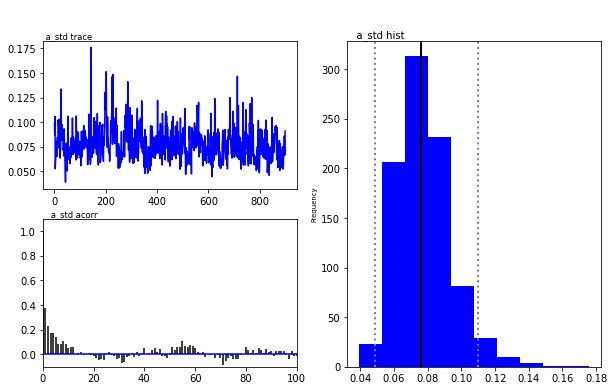

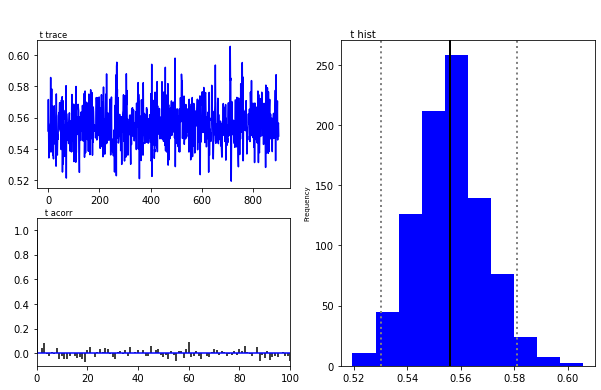

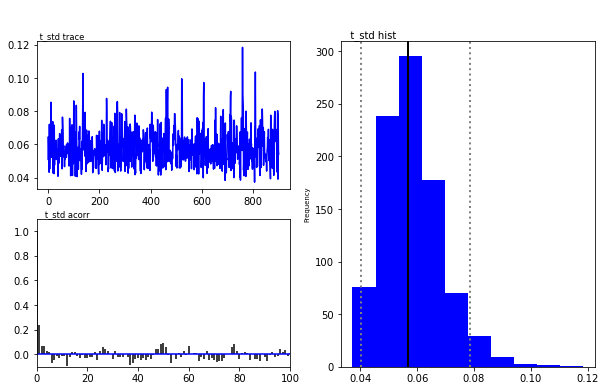

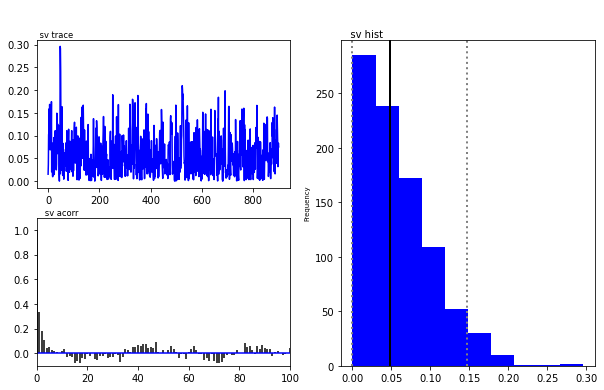

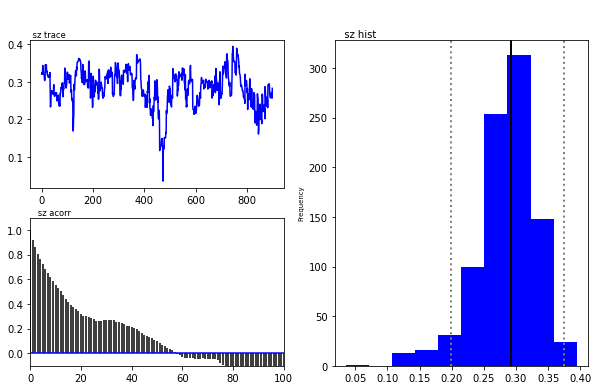

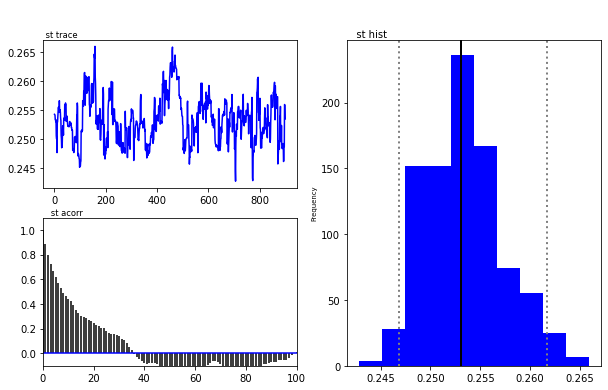

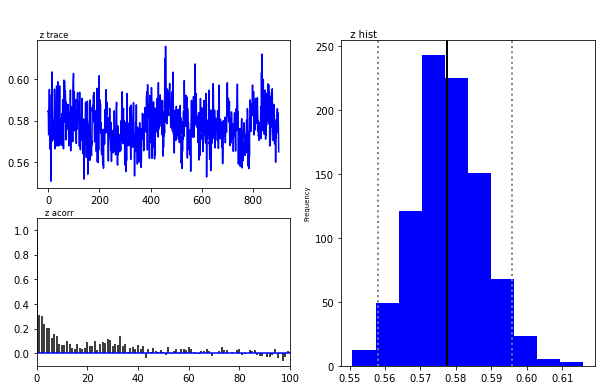

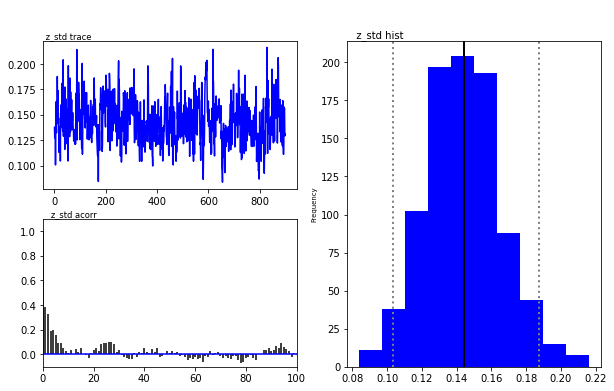

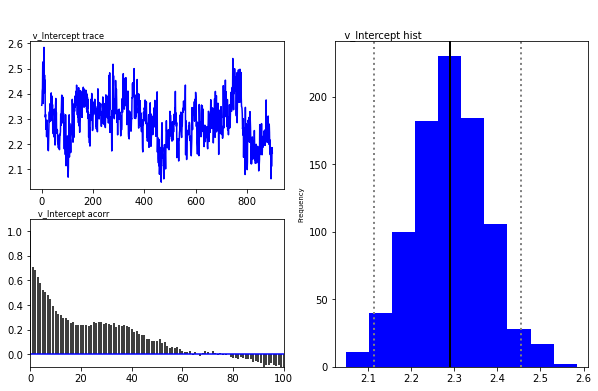

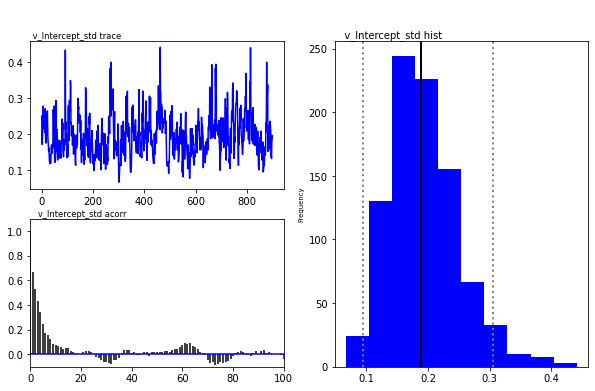

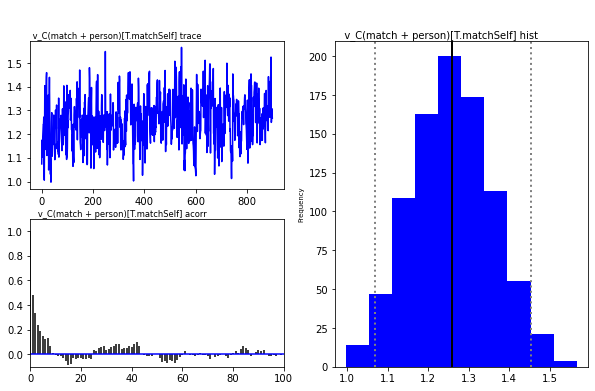

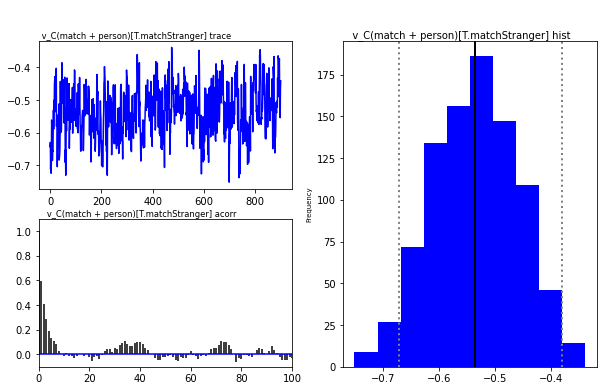

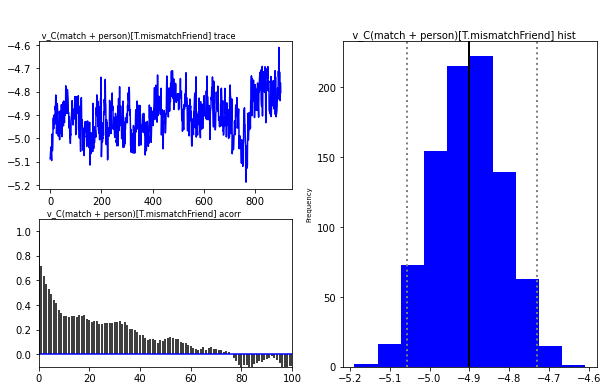

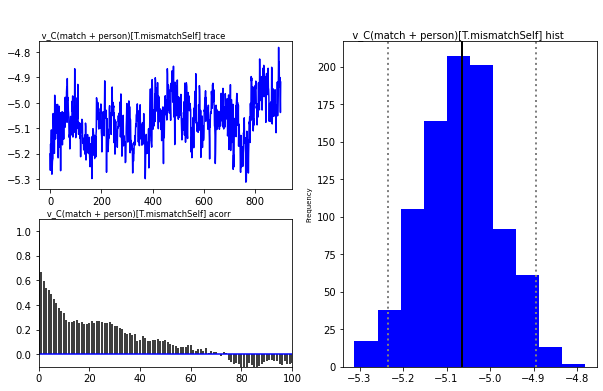

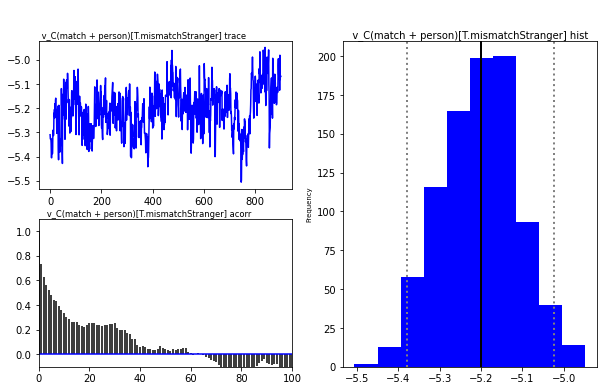

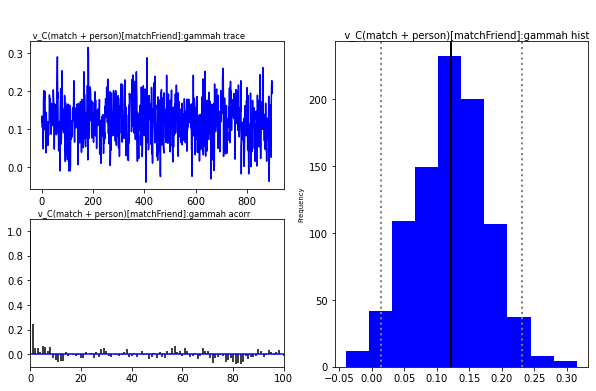

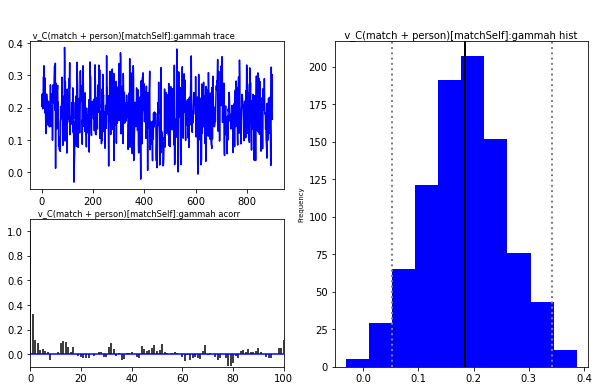

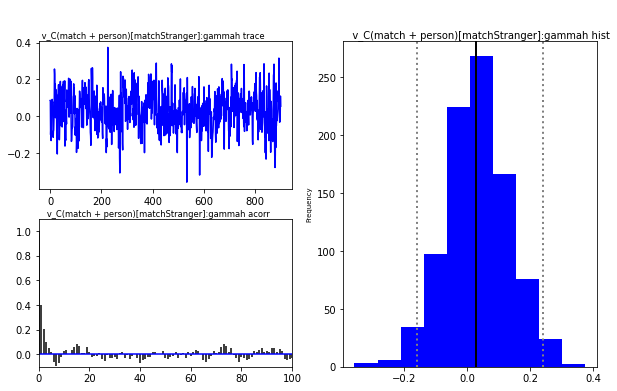

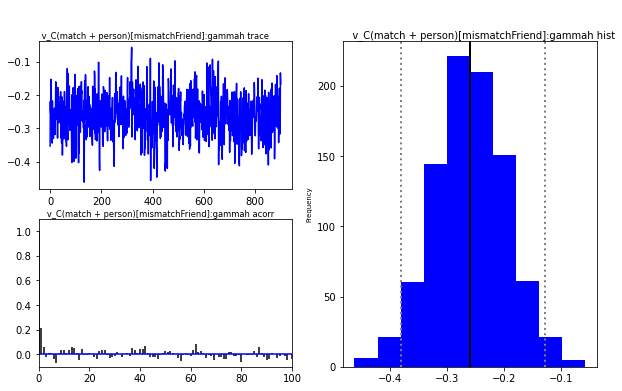

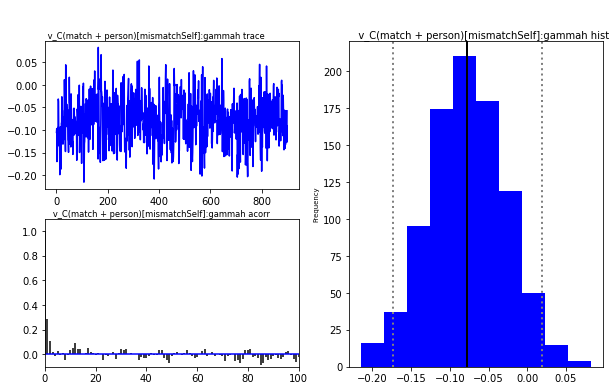

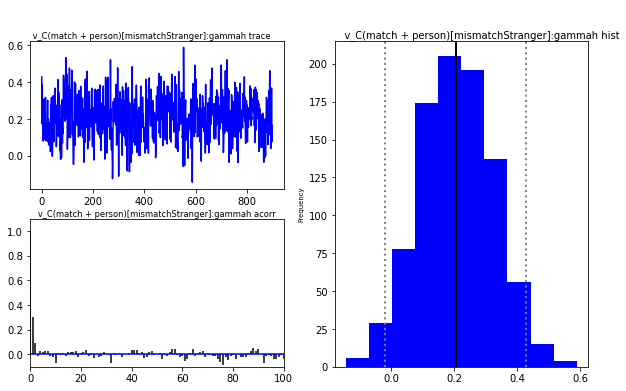

In [49]:
###### convergence check

reg_m9.plot_posteriors()